In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.8.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# define  dataset tho

In [ ]:
import json
import os
import os.path as osp
from typing import Callable, List, Optional, Union

import torch

from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from torch_geometric.io import fs, read_txt_array


class BreakBad(InMemoryDataset):
    r"""The ShapeNet part level segmentation dataset from the `"A Scalable
    Active Framework for Region Annotation in 3D Shape Collections"
    <http://web.stanford.edu/~ericyi/papers/part_annotation_16_small.pdf>`_
    paper, containing about 17,000 3D shape point clouds from 16 shape
    categories.
    Each category is annotated with 2 to 6 parts.

    Args:
        root (str): Root directory where the dataset should be saved.
        categories (str or [str], optional): The category of the CAD models
            (one or a combination of :obj:`"Airplane"`, :obj:`"Bag"`,
            :obj:`"Cap"`, :obj:`"Car"`, :obj:`"Chair"`, :obj:`"Earphone"`,
            :obj:`"Guitar"`, :obj:`"Knife"`, :obj:`"Lamp"`, :obj:`"Laptop"`,
            :obj:`"Motorbike"`, :obj:`"Mug"`, :obj:`"Pistol"`, :obj:`"Rocket"`,
            :obj:`"Skateboard"`, :obj:`"Table"`).
            Can be explicitly set to :obj:`None` to load all categories.
            (default: :obj:`None`)
        include_normals (bool, optional): If set to :obj:`False`, will not
            include normal vectors as input features to :obj:`data.x`.
            As a result, :obj:`data.x` will be :obj:`None`.
            (default: :obj:`True`)
        split (str, optional): If :obj:`"train"`, loads the training dataset.
            If :obj:`"val"`, loads the validation dataset.
            If :obj:`"trainval"`, loads the training and validation dataset.
            If :obj:`"test"`, loads the test dataset.
            (default: :obj:`"trainval"`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10 10
        :header-rows: 1

        * - #graphs
          - #nodes
          - #edges
          - #features
          - #classes
        * - 16,881
          - ~2,616.2
          - 0
          - 3
          - 50
    """

    url = ('https://shapenet.cs.stanford.edu/media/'
           'shapenetcore_partanno_segmentation_benchmark_v0_normal.zip')

    # In case `shapenet.cs.stanford.edu` is offline, try to download the data
    # from Kaggle instead (requires login):
    # https://www.kaggle.com/datasets/mitkir/shapenet/download?datasetVersionNumber=1

    category_ids = {
        'Solid_obj': 'solid',
        'Not_Solid_obj': 'not_solid'
    }



    seg_classes = {
        'Solid_obj': [0,1],
        'Not_Solid_obj': [2,3]
    }

    def __init__(
        self,
        root: str,
        categories: Optional[Union[str, List[str]]] = None,
        include_normals: bool = True,
        split: str = 'trainval',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        if categories is None:
            categories = list(self.category_ids.keys())
        if isinstance(categories, str):
            categories = [categories]
        print(categories)
        assert all(category in self.category_ids for category in categories)
        self.categories = categories
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'val':
            path = self.processed_paths[1]
        elif split == 'test':
            path = self.processed_paths[2]
        elif split == 'trainval':
            path = self.processed_paths[3]
        else:
            raise ValueError(f'Split {split} found, but expected either '
                             'train, val, trainval or test')

        self.load(path)

        assert isinstance(self._data, Data)
        self._data.x = self._data.x if include_normals else None

        self.y_mask = torch.zeros((len(self.seg_classes.keys()),len(self.seg_classes.keys())*2),
                                  dtype=torch.bool)
        for i, labels in enumerate(self.seg_classes.values()):
            self.y_mask[i, labels] = 1

    @property
    def num_classes(self) -> int:
        return self.y_mask.size(-1)

    @property
    def raw_file_names(self) -> List[str]:
        return list(self.category_ids.values()) + ['train_test_split']

    @property
    def processed_file_names(self) -> List[str]:
        cats = '_'.join([cat[:3].lower() for cat in self.categories])
        return [
            osp.join(f'{cats}_{split}.pt')
            for split in ['train', 'val', 'test', 'trainval']
        ]

    def download(self) -> None:
        pass

    def process_filenames(self, filenames: List[str]) -> List[Data]:
        rank_ids = {
        'solid' : 0,
        'not_solid' : 1

        }
        data_list = []
        categories_ids = [self.category_ids[cat] for cat in self.categories]
        cat_idx = {categories_ids[i]: i for i in range(len(categories_ids))}

        for name in filenames:
            cat = name.split(osp.sep)[0]
            if cat not in categories_ids:
                continue
            my_custom_idx = rank_ids[cat]
            tensor = read_txt_array(osp.join(self.raw_dir, name))
            pos = tensor[:, :3]
            x = tensor[:, 3:6]
            y = tensor[:, -1].type(torch.long)+2*my_custom_idx
            data = Data(pos=pos, x=x, y=y, category=cat_idx[cat])
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        return data_list

    def process(self) -> None:
        trainval = []
        for i, split in enumerate(['train', 'val', 'test']):
            path = osp.join(self.raw_dir, 'train_test_split',
                            f'shuffled_{split}_file_list.json')
            with open(path) as f:
                filenames = [
                    osp.sep.join(name.split('/')[1:]) + '.txt'
                    for name in json.load(f)
                ]  # Removing first directory.
            data_list = self.process_filenames(filenames)
            if split == 'train' or split == 'val':
                trainval += data_list
            self.save(data_list, self.processed_paths[i])
        self.save(trainval, self.processed_paths[3])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, '
                f'categories={self.categories})')


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import MLP, DynamicEdgeConv


import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, knn_interpolate
from torch_geometric.typing import WITH_TORCH_CLUSTER
from torch_geometric.utils import scatter


In [ ]:
!unzip /content/solid_all_class.zip -d /content/temp_extract
!mkdir /content/data
!mkdir /content/data/raw
!mv /content/temp_extract/solid_all_class/* /content/data/raw
!rm -r /content/temp_extract

Archive:  /content/solid_all_class.zip
   creating: /content/temp_extract/solid_all_class/
   creating: /content/temp_extract/solid_all_class/not_solid/
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_22.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_41.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_59.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_70.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_72.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_75.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_76.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_mode_11.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_

In [ ]:
category = 'Solid_obj'  # Pass in `None` to train on all categories.
path = "/content/data"
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])
pre_transform = T.NormalizeScale()
train_dataset = BreakBad(path, category, split='trainval', transform=transform,
                         pre_transform=pre_transform)
test_dataset = BreakBad(path, category, split='test',
                        pre_transform=pre_transform)
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True,
                          num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False,
                         num_workers=2)

['Solid_obj']


Processing...


['Solid_obj']


Done!


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import torch
import random
import numpy as np

gt_cmap = np.array([
    [0.121, 0.466, 0.705],  # Blue for class 0
    [1.000, 0.498, 0.054],  # Orange for class 1
])

@torch.no_grad()
def visualize_ground_truth_3d(loader, num_samples=4):
    # Load all data samples into a list for random access
    all_data = list(loader)

    sampled_data = random.sample(all_data, min(num_samples, len(all_data)))
    sample_id = 1

    for data in sampled_data:
        data = data.to(device)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)
        ys = data.y.split(sizes)

        for x, y in zip(xs, ys):
            x_np = x.cpu().numpy()
            y_np = y.cpu().numpy()

            # Convert y labels to RGB colors using gt_cmap
            colors = gt_cmap[y_np%2]
            print(f"Unique classes {np.unique(y_np)}")
            fig = plt.figure(figsize=(6, 5))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(x_np[:, 0], x_np[:, 1], x_np[:, 2], c=colors, s=5)
            ax.set_title(f'Ground Truth - Sample {sample_id}')
            ax.set_axis_off()
            plt.tight_layout()
            plt.show()

            sample_id += 1
            if sample_id > num_samples:
                return


Unique classes [0 1]


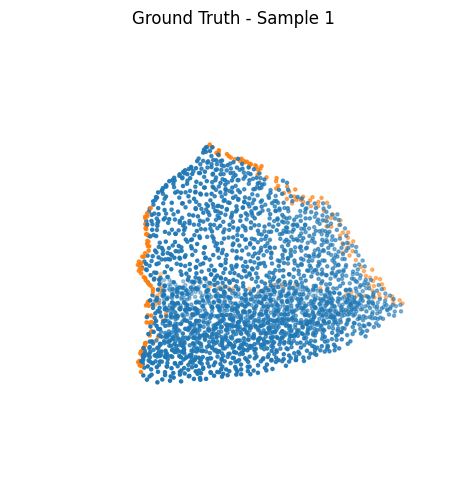

Unique classes [0 1]


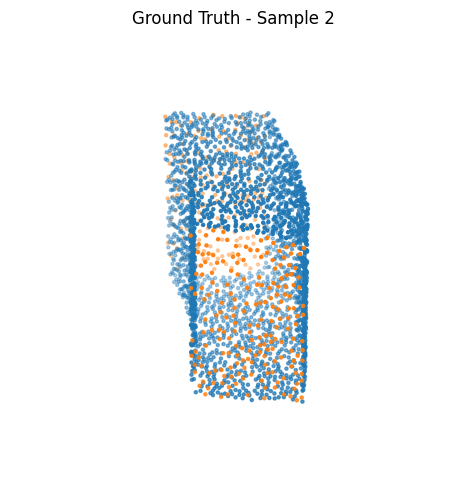

Unique classes [0 1]


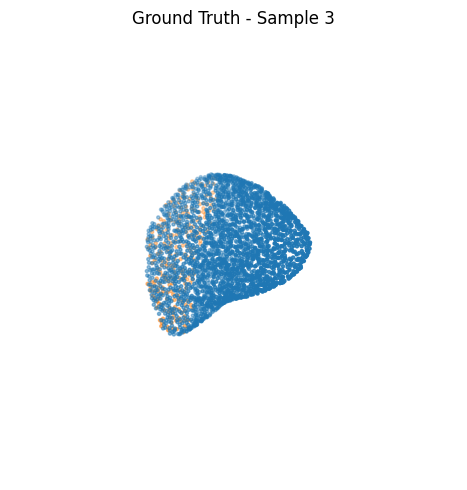

Unique classes [0 1]


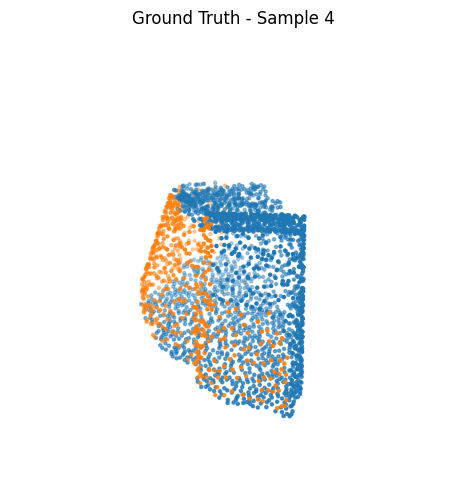

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_ground_truth_3d(test_loader, num_samples=4)

# RanlaNet

In [ ]:
from torch_geometric.nn import MLP, DynamicEdgeConv
class Net(torch.nn.Module):
    def __init__(self, out_channels, k=30, aggr='max'):
        super().__init__()

        self.conv1 = DynamicEdgeConv(MLP([2 * 6, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 64, 64]), k, aggr)
        self.conv3 = DynamicEdgeConv(MLP([2 * 64, 64, 64]), k, aggr)

        self.mlp = MLP([3 * 64, 1024, 256, 128, out_channels], dropout=0.5,
                       norm=None)

    def forward(self, data):
        x, pos, batch = data.x, data.pos, data.batch
        x0 = torch.cat([x, pos], dim=-1)
        x1 = self.conv1(x0, batch)
        x2 = self.conv2(x1, batch)
        x3 = self.conv3(x2, batch)
        out = self.mlp(torch.cat([x1, x2, x3], dim=1))
        return F.log_softmax(out, dim=1)

In [ ]:
def jaccard_index(pred: torch.Tensor, target: torch.Tensor, num_classes: int, absent_score: float = 1.0) -> float:
    """
    Compute mean Intersection over Union (IoU) between predicted and target labels.

    Args:
        pred (Tensor): Predicted labels (1D tensor of shape [N]).
        target (Tensor): Ground truth labels (1D tensor of shape [N]).
        num_classes (int): Number of classes to consider (usually the number of part labels for a category).
        absent_score (float): Score to assign if a class is absent in both pred and target.

    Returns:
        float: Mean IoU over classes.
    """
    device = pred.device
    ious = []

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)

        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()

        if union == 0:
            iou = torch.tensor(absent_score, device=device)
        else:
            iou = intersection.float() / union.float()
        ious.append(iou)

    # Stack and compute mean
    return torch.stack(ious).mean().item()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(train_dataset.num_classes, k=30).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)


In [ ]:


import matplotlib.pyplot as plt

def train():
    model.train()
    loss_list = []
    acc_list = []
    total_loss = correct_nodes = total_nodes = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_nodes += out.argmax(dim=1).eq(data.y).sum().item()
        total_nodes += data.num_nodes

        if (i + 1) % 10 == 0:
            tloss = total_loss / 10
            tacc = correct_nodes / total_nodes
            print(f'[{i+1}/{len(train_loader)}] Loss: {tloss:.4f} '
                  f'Train Acc: {tacc:.4f}')
            total_loss = correct_nodes = total_nodes = 0
            loss_list.append(tloss)
            acc_list.append(tacc)

    return np.mean(loss_list), np.mean(acc_list)

@torch.no_grad()
def test(loader):
    model.eval()

    ious, categories = [], []
    y_map = torch.empty(loader.dataset.num_classes, device=device).long()
    for data in loader:
        data = data.to(device)
        outs = model(data)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        for out, y, category in zip(outs.split(sizes), data.y.split(sizes),
                                    data.category.tolist()):
            category = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)


            iou = jaccard_index(out[:, part].argmax(dim=-1), y_map[y],
                                num_classes=part.size(0), absent_score=1.0)
            ious.append(iou)
        categories.append(data.category)

    iou = torch.tensor(ious, device=device)
    category = torch.cat(categories, dim=0)

    mean_iou = scatter(iou, category, reduce='mean')  # Per-category IoU.
    return float(mean_iou.mean())  # Global IoU.

def plot_iou_over_epochs(iou_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(iou_list) + 1), iou_list, marker='o', color='dodgerblue')
    plt.title('IoU over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test IoU')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_loss_over_epochs(iou_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(iou_list) + 1), iou_list, marker='o', color='orange')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()





[10/89] Loss: 0.7361 Train Acc: 0.7233
[20/89] Loss: 0.4569 Train Acc: 0.7966
[30/89] Loss: 0.4175 Train Acc: 0.8008
[40/89] Loss: 0.4148 Train Acc: 0.8089
[50/89] Loss: 0.3709 Train Acc: 0.8215
[60/89] Loss: 0.3209 Train Acc: 0.8541
[70/89] Loss: 0.3189 Train Acc: 0.8576
[80/89] Loss: 0.3456 Train Acc: 0.8477
Epoch: 01, Test IoU: 0.6643


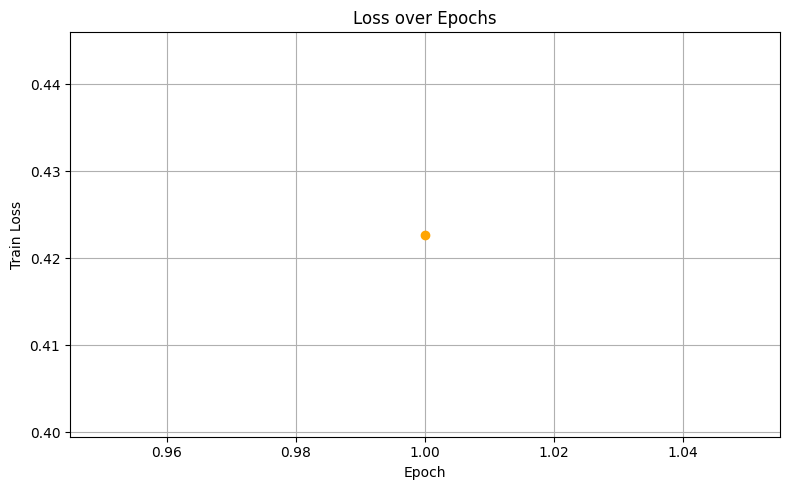

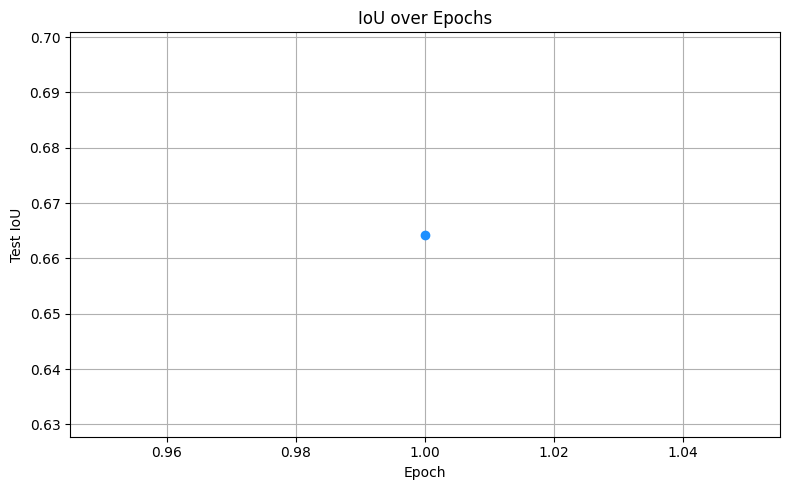

  >> Best model saved at epoch 1 with IoU: 0.6643
[10/89] Loss: 0.3277 Train Acc: 0.8707
[20/89] Loss: 0.2970 Train Acc: 0.8804
[30/89] Loss: 0.2728 Train Acc: 0.8916
[40/89] Loss: 0.2691 Train Acc: 0.8983
[50/89] Loss: 0.2209 Train Acc: 0.9240
[60/89] Loss: 0.2499 Train Acc: 0.9086
[70/89] Loss: 0.2100 Train Acc: 0.9270
[80/89] Loss: 0.2092 Train Acc: 0.9274
Epoch: 02, Test IoU: 0.8358


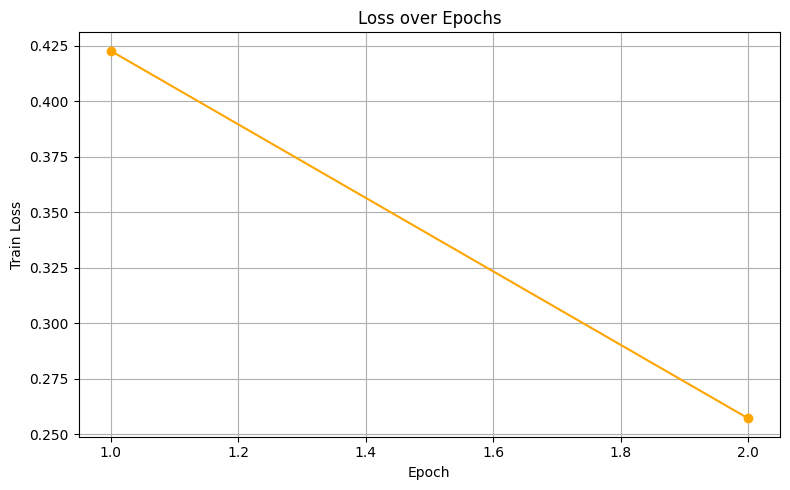

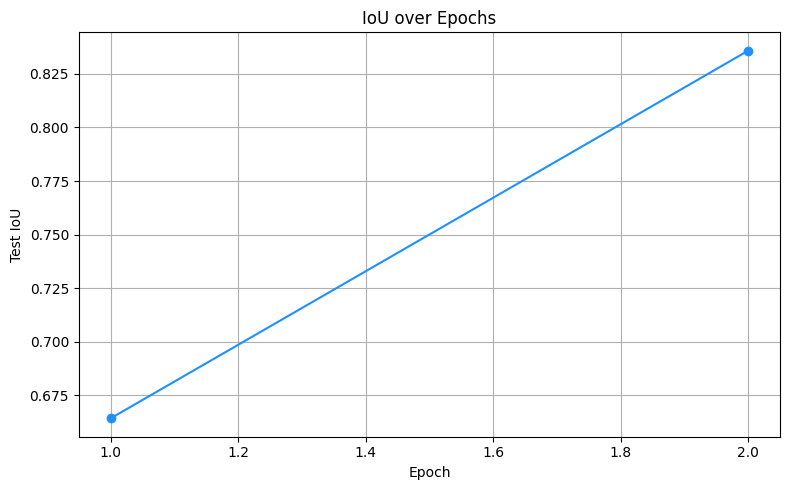

  >> Best model saved at epoch 2 with IoU: 0.8358
[10/89] Loss: 0.1787 Train Acc: 0.9417
[20/89] Loss: 0.1775 Train Acc: 0.9359
[30/89] Loss: 0.2179 Train Acc: 0.9239
[40/89] Loss: 0.1862 Train Acc: 0.9321
[50/89] Loss: 0.2117 Train Acc: 0.9271
[60/89] Loss: 0.1938 Train Acc: 0.9293
[70/89] Loss: 0.1769 Train Acc: 0.9415
[80/89] Loss: 0.2125 Train Acc: 0.9317
Epoch: 03, Test IoU: 0.8794


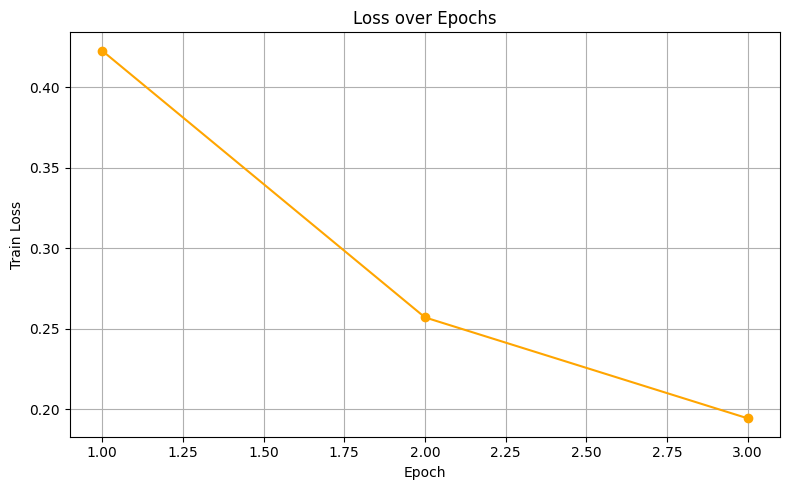

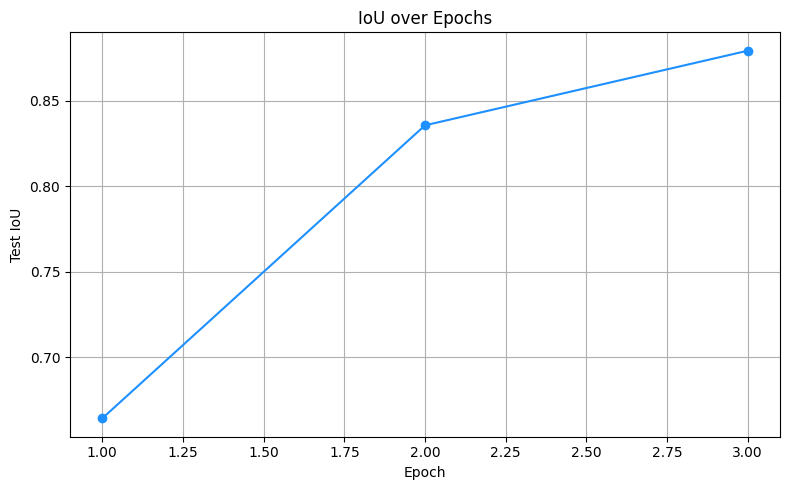

  >> Best model saved at epoch 3 with IoU: 0.8794
[10/89] Loss: 0.1623 Train Acc: 0.9450
[20/89] Loss: 0.1629 Train Acc: 0.9469
[30/89] Loss: 0.1340 Train Acc: 0.9566
[40/89] Loss: 0.1439 Train Acc: 0.9521
[50/89] Loss: 0.1541 Train Acc: 0.9460
[60/89] Loss: 0.1383 Train Acc: 0.9509
[70/89] Loss: 0.1479 Train Acc: 0.9536
[80/89] Loss: 0.1680 Train Acc: 0.9387
Epoch: 04, Test IoU: 0.8900


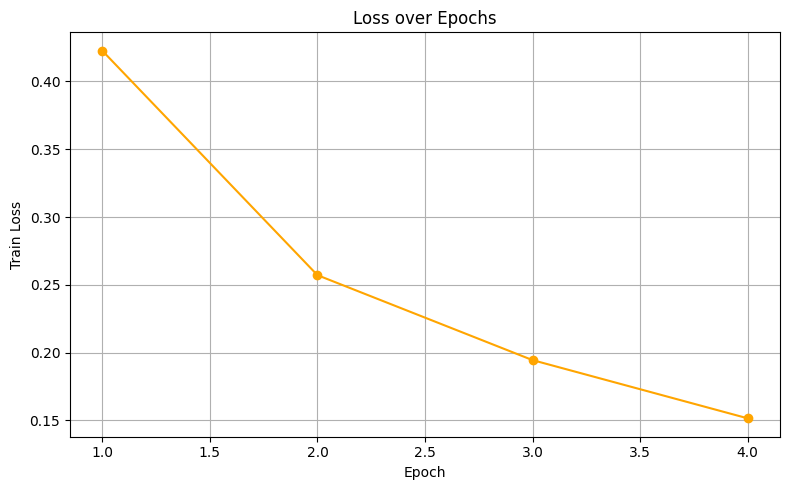

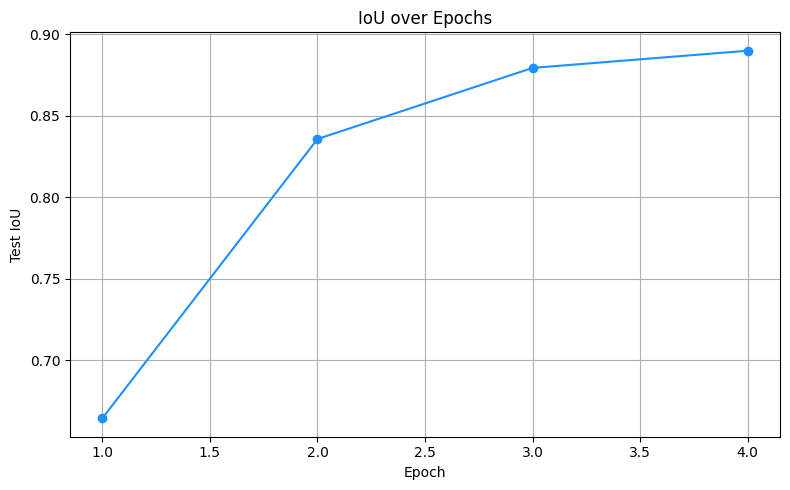

  >> Best model saved at epoch 4 with IoU: 0.8900
[10/89] Loss: 0.1423 Train Acc: 0.9510
[20/89] Loss: 0.1335 Train Acc: 0.9567
[30/89] Loss: 0.1251 Train Acc: 0.9573
[40/89] Loss: 0.1326 Train Acc: 0.9561
[50/89] Loss: 0.1423 Train Acc: 0.9534
[60/89] Loss: 0.1130 Train Acc: 0.9622
[70/89] Loss: 0.1187 Train Acc: 0.9611
[80/89] Loss: 0.1309 Train Acc: 0.9541
Epoch: 05, Test IoU: 0.9221


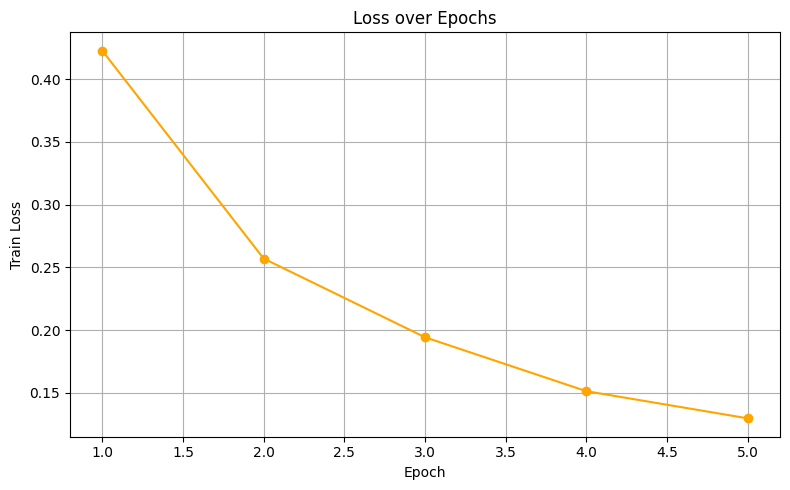

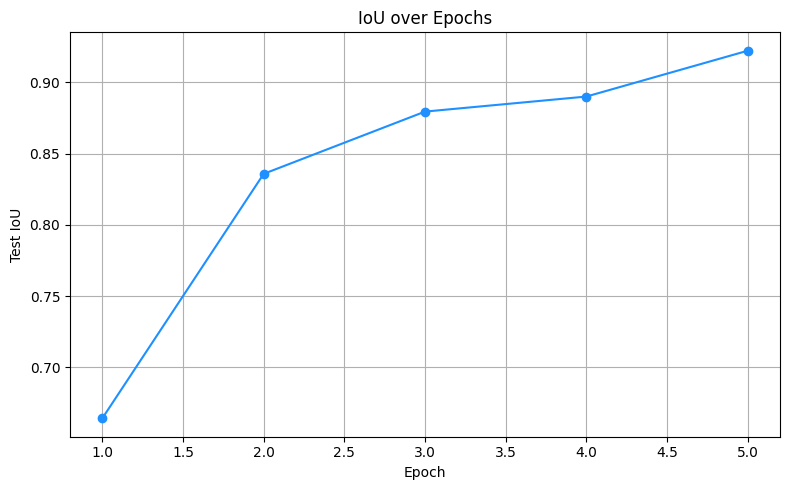

  >> Best model saved at epoch 5 with IoU: 0.9221
[10/89] Loss: 0.1044 Train Acc: 0.9678
[20/89] Loss: 0.1524 Train Acc: 0.9523
[30/89] Loss: 0.1424 Train Acc: 0.9529
[40/89] Loss: 0.1072 Train Acc: 0.9654
[50/89] Loss: 0.1332 Train Acc: 0.9558
[60/89] Loss: 0.1223 Train Acc: 0.9588
[70/89] Loss: 0.1033 Train Acc: 0.9648
[80/89] Loss: 0.1094 Train Acc: 0.9617
Epoch: 06, Test IoU: 0.9297


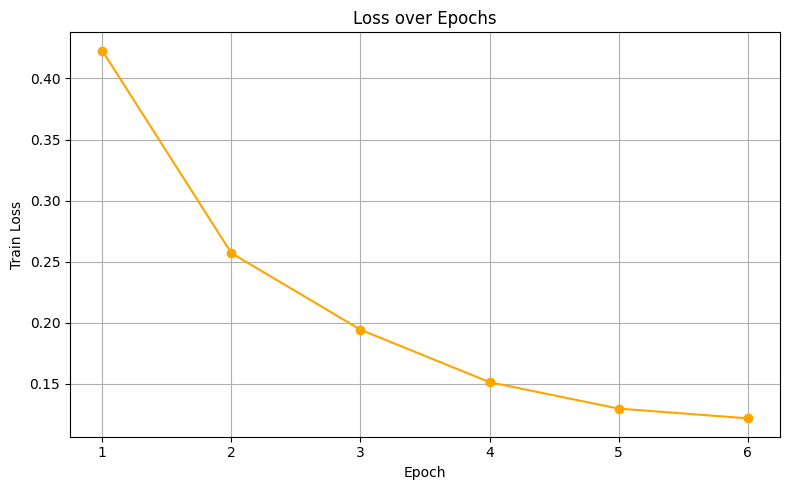

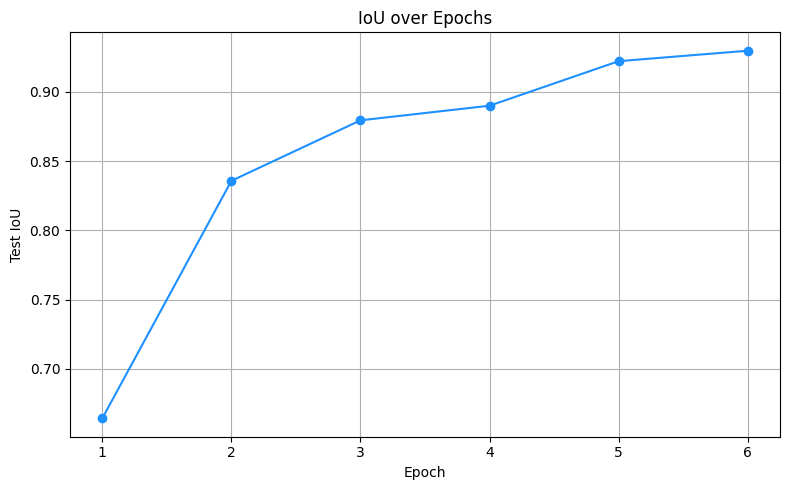

  >> Best model saved at epoch 6 with IoU: 0.9297
[10/89] Loss: 0.1086 Train Acc: 0.9628
[20/89] Loss: 0.1187 Train Acc: 0.9577
[30/89] Loss: 0.1216 Train Acc: 0.9607
[40/89] Loss: 0.1200 Train Acc: 0.9595
[50/89] Loss: 0.1050 Train Acc: 0.9659
[60/89] Loss: 0.0940 Train Acc: 0.9677
[70/89] Loss: 0.0874 Train Acc: 0.9697
[80/89] Loss: 0.0993 Train Acc: 0.9671
Epoch: 07, Test IoU: 0.9291


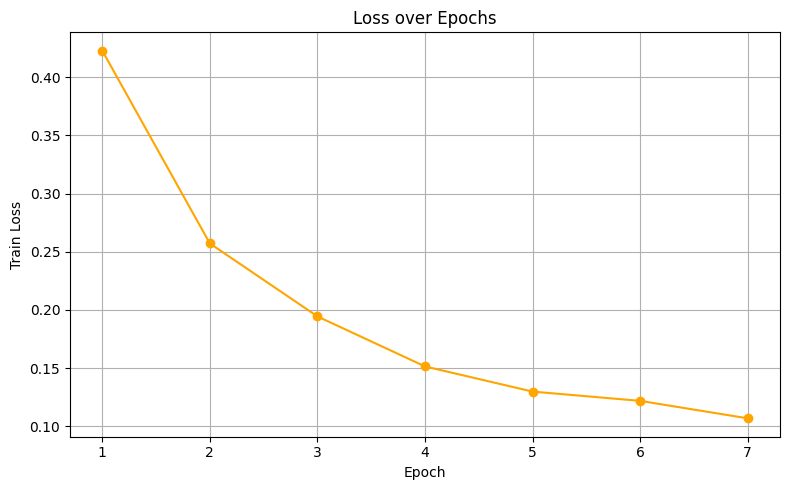

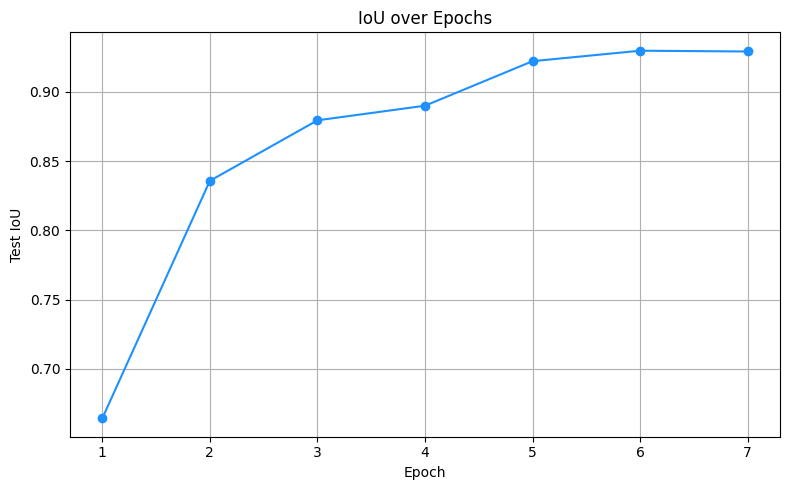

[10/89] Loss: 0.0965 Train Acc: 0.9681
[20/89] Loss: 0.1064 Train Acc: 0.9682
[30/89] Loss: 0.0990 Train Acc: 0.9682
[40/89] Loss: 0.1188 Train Acc: 0.9576
[50/89] Loss: 0.0768 Train Acc: 0.9749
[60/89] Loss: 0.1339 Train Acc: 0.9563
[70/89] Loss: 0.1104 Train Acc: 0.9622
[80/89] Loss: 0.0906 Train Acc: 0.9708
Epoch: 08, Test IoU: 0.9171


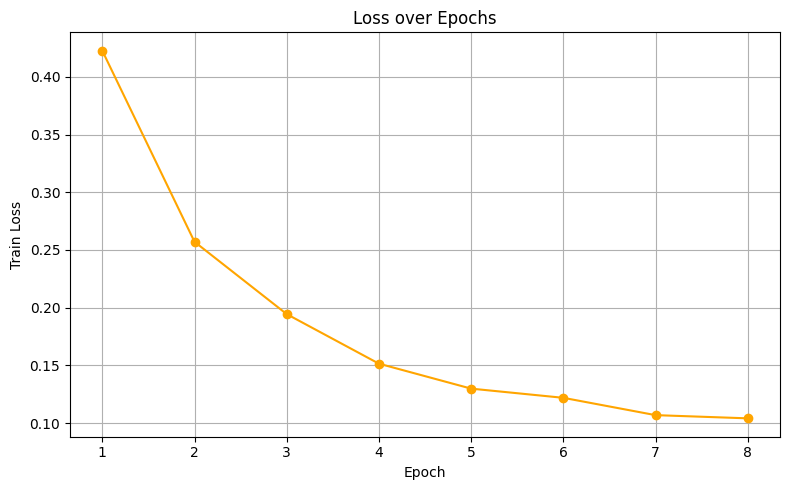

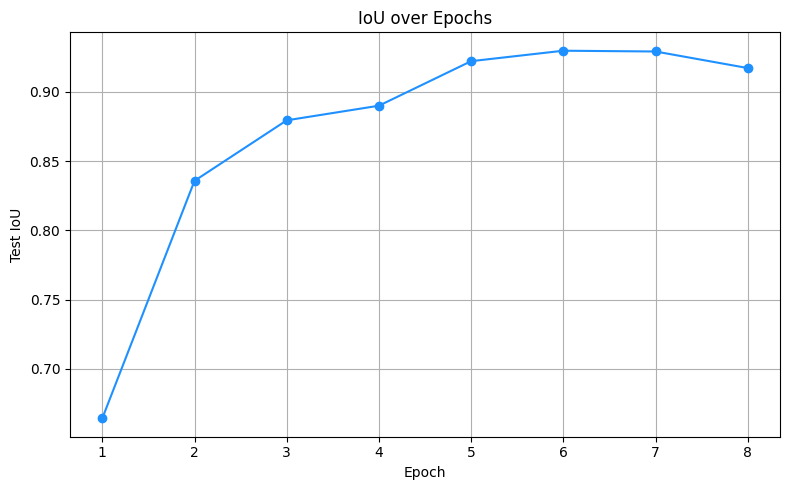

[10/89] Loss: 0.0926 Train Acc: 0.9687
[20/89] Loss: 0.0918 Train Acc: 0.9704
[30/89] Loss: 0.0777 Train Acc: 0.9755
[40/89] Loss: 0.1247 Train Acc: 0.9633
[50/89] Loss: 0.1015 Train Acc: 0.9645
[60/89] Loss: 0.1158 Train Acc: 0.9581
[70/89] Loss: 0.1026 Train Acc: 0.9659
[80/89] Loss: 0.0709 Train Acc: 0.9777
Epoch: 09, Test IoU: 0.9412


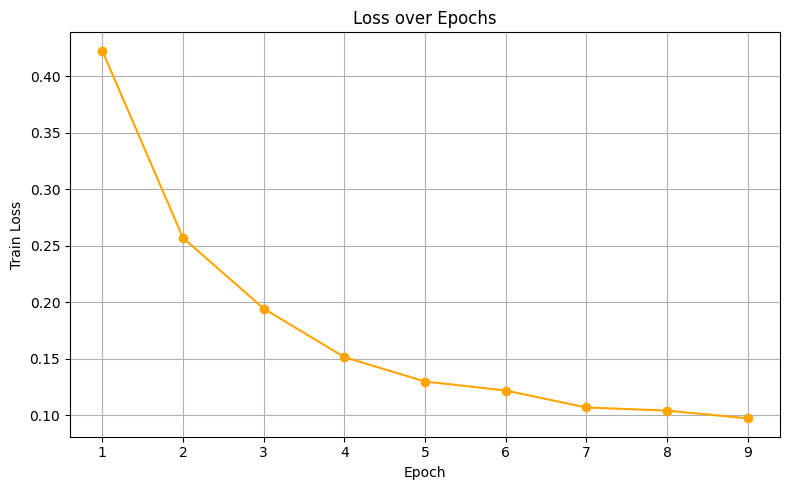

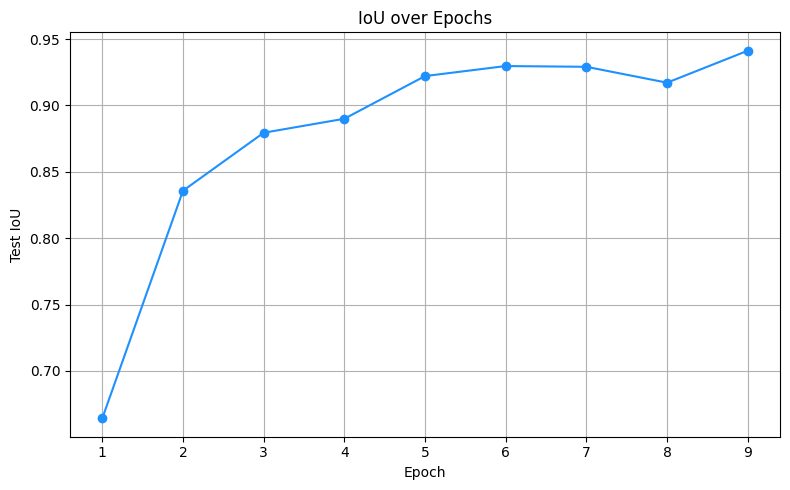

  >> Best model saved at epoch 9 with IoU: 0.9412
[10/89] Loss: 0.0781 Train Acc: 0.9748
[20/89] Loss: 0.0853 Train Acc: 0.9703
[30/89] Loss: 0.1011 Train Acc: 0.9671
[40/89] Loss: 0.0674 Train Acc: 0.9776
[50/89] Loss: 0.0771 Train Acc: 0.9753
[60/89] Loss: 0.0792 Train Acc: 0.9734
[70/89] Loss: 0.0765 Train Acc: 0.9749
[80/89] Loss: 0.0746 Train Acc: 0.9766
Epoch: 10, Test IoU: 0.9390


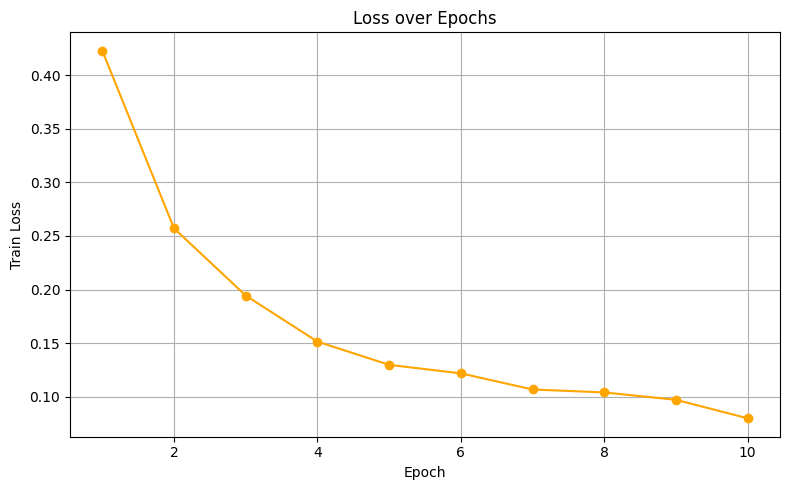

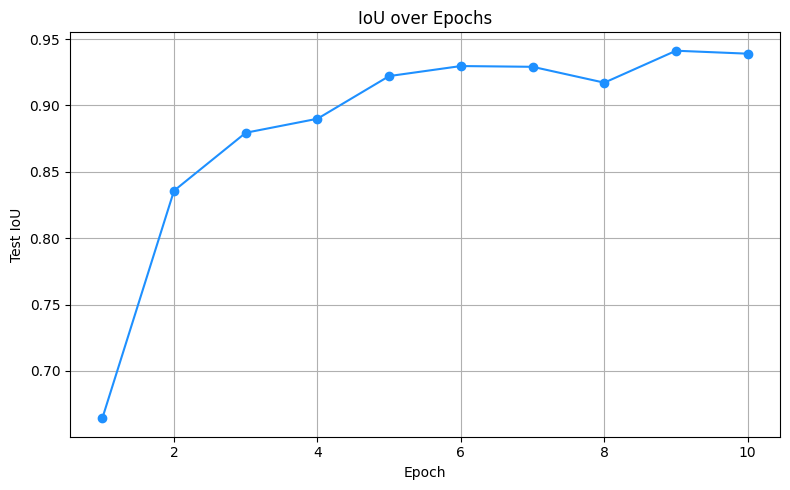

[10/89] Loss: 0.0810 Train Acc: 0.9740
[20/89] Loss: 0.0716 Train Acc: 0.9769
[30/89] Loss: 0.0715 Train Acc: 0.9775
[40/89] Loss: 0.0856 Train Acc: 0.9717
[50/89] Loss: 0.0811 Train Acc: 0.9724
[60/89] Loss: 0.0790 Train Acc: 0.9750
[70/89] Loss: 0.0656 Train Acc: 0.9787
[80/89] Loss: 0.0868 Train Acc: 0.9734
Epoch: 11, Test IoU: 0.9494


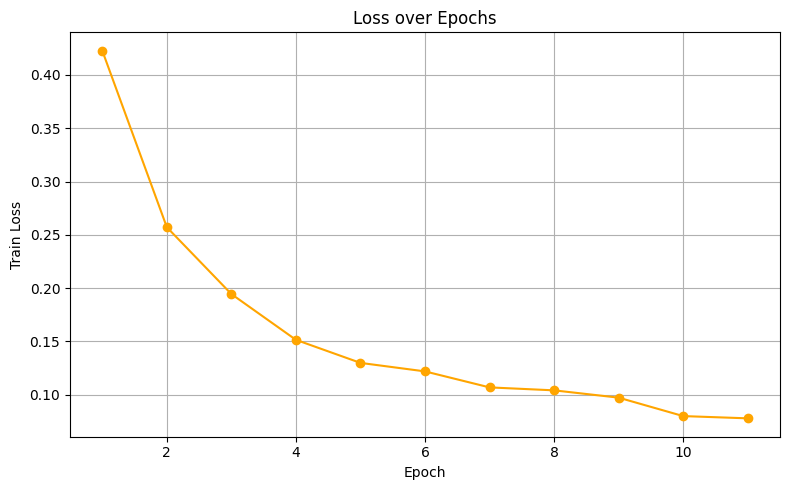

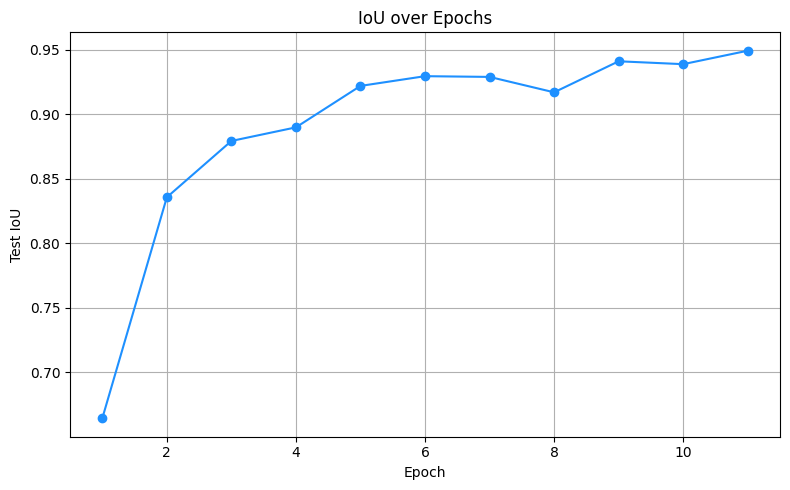

  >> Best model saved at epoch 11 with IoU: 0.9494
[10/89] Loss: 0.0550 Train Acc: 0.9825
[20/89] Loss: 0.0516 Train Acc: 0.9849
[30/89] Loss: 0.1137 Train Acc: 0.9618
[40/89] Loss: 0.0693 Train Acc: 0.9773
[50/89] Loss: 0.0639 Train Acc: 0.9796
[60/89] Loss: 0.0659 Train Acc: 0.9783
[70/89] Loss: 0.1029 Train Acc: 0.9675
[80/89] Loss: 0.0785 Train Acc: 0.9753
Epoch: 12, Test IoU: 0.9300


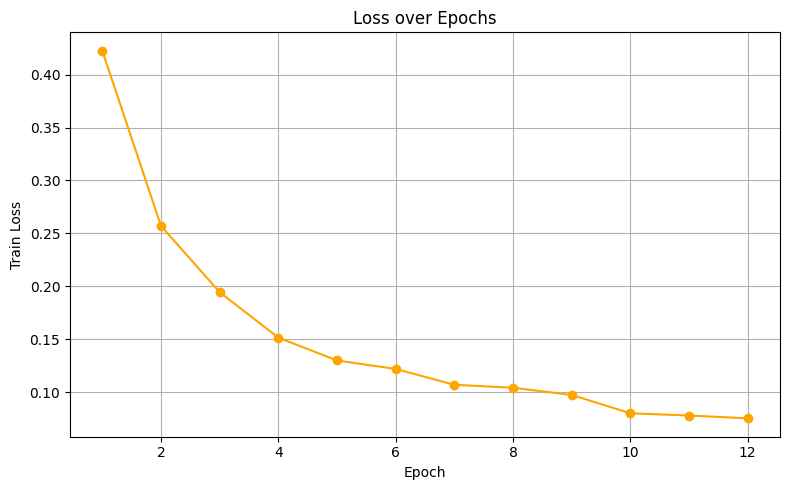

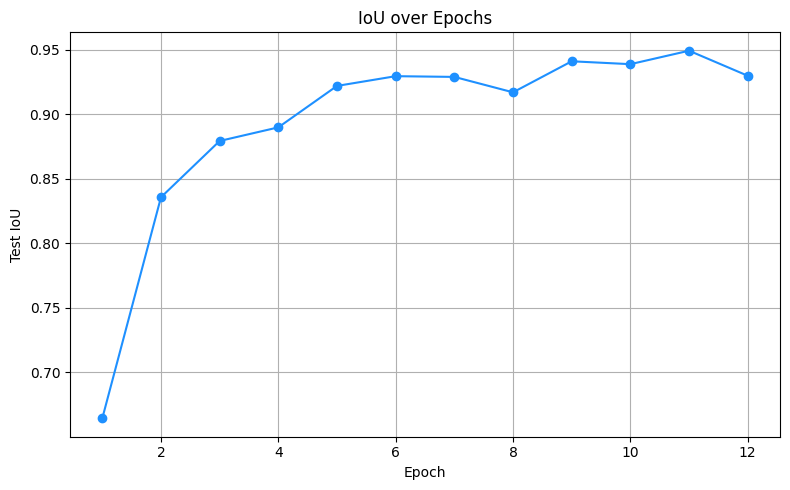

[10/89] Loss: 0.0987 Train Acc: 0.9656
[20/89] Loss: 0.0785 Train Acc: 0.9760
[30/89] Loss: 0.0849 Train Acc: 0.9719
[40/89] Loss: 0.0694 Train Acc: 0.9781
[50/89] Loss: 0.0790 Train Acc: 0.9745
[60/89] Loss: 0.0580 Train Acc: 0.9819
[70/89] Loss: 0.0700 Train Acc: 0.9772
[80/89] Loss: 0.0653 Train Acc: 0.9792
Epoch: 13, Test IoU: 0.9472


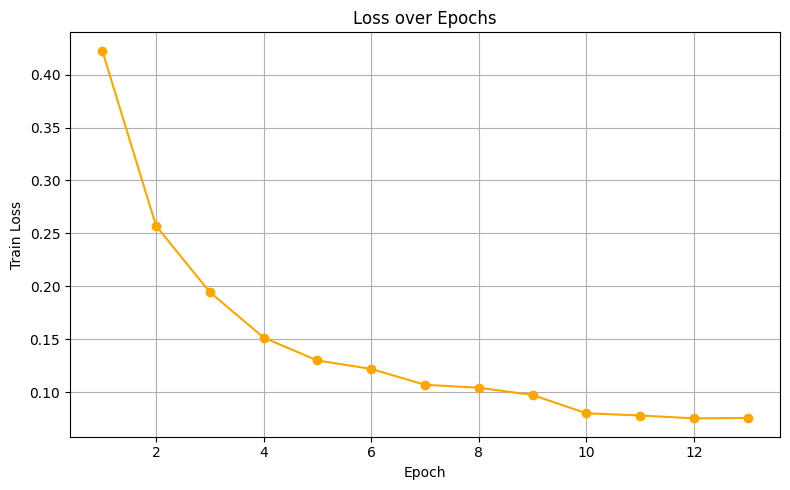

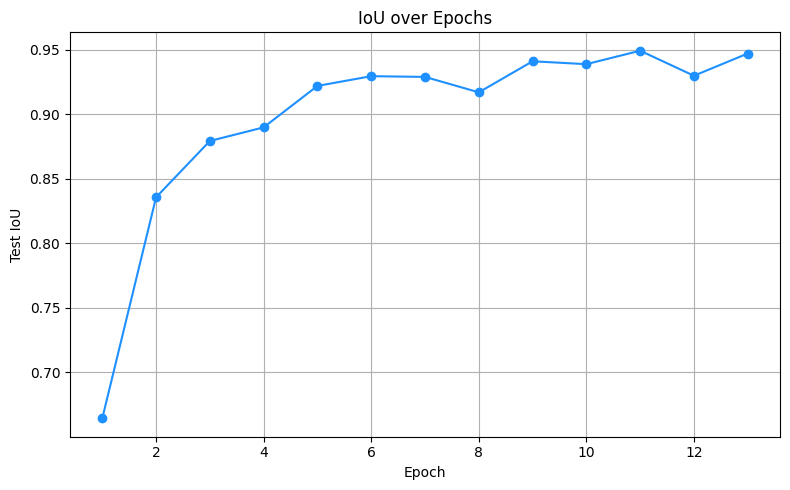

[10/89] Loss: 0.0699 Train Acc: 0.9762
[20/89] Loss: 0.0771 Train Acc: 0.9738
[30/89] Loss: 0.0619 Train Acc: 0.9786
[40/89] Loss: 0.0692 Train Acc: 0.9770
[50/89] Loss: 0.0881 Train Acc: 0.9716
[60/89] Loss: 0.0605 Train Acc: 0.9792
[70/89] Loss: 0.0668 Train Acc: 0.9795
[80/89] Loss: 0.0604 Train Acc: 0.9819
Epoch: 14, Test IoU: 0.9474


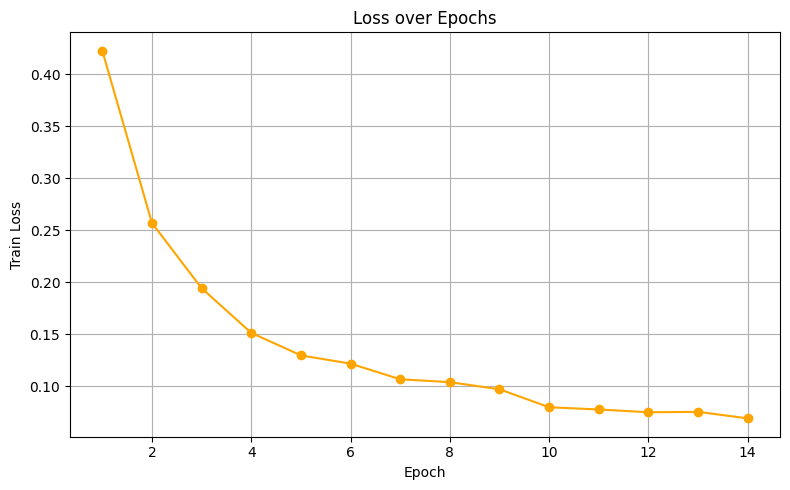

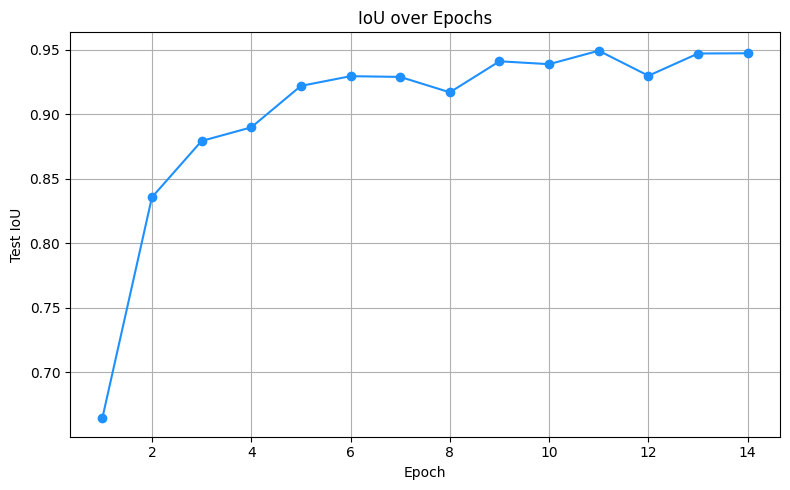

[10/89] Loss: 0.0578 Train Acc: 0.9813
[20/89] Loss: 0.0754 Train Acc: 0.9775
[30/89] Loss: 0.0556 Train Acc: 0.9822
[40/89] Loss: 0.0516 Train Acc: 0.9842
[50/89] Loss: 0.0651 Train Acc: 0.9786
[60/89] Loss: 0.0705 Train Acc: 0.9765
[70/89] Loss: 0.0684 Train Acc: 0.9790
[80/89] Loss: 0.0617 Train Acc: 0.9787
Epoch: 15, Test IoU: 0.9504


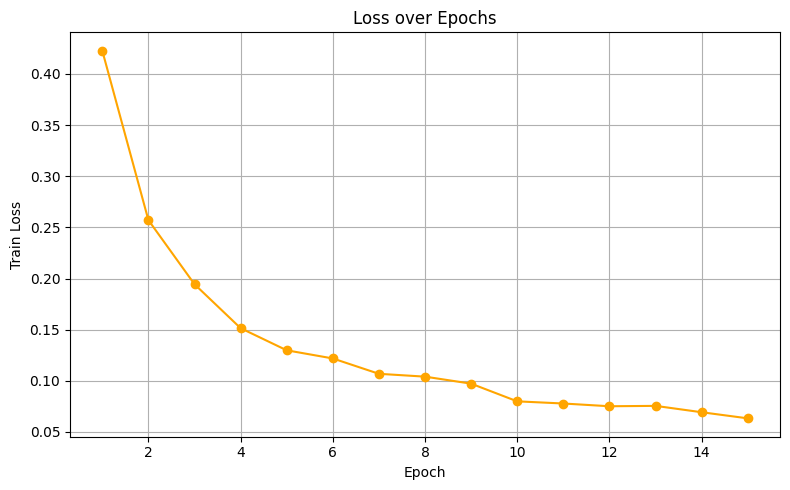

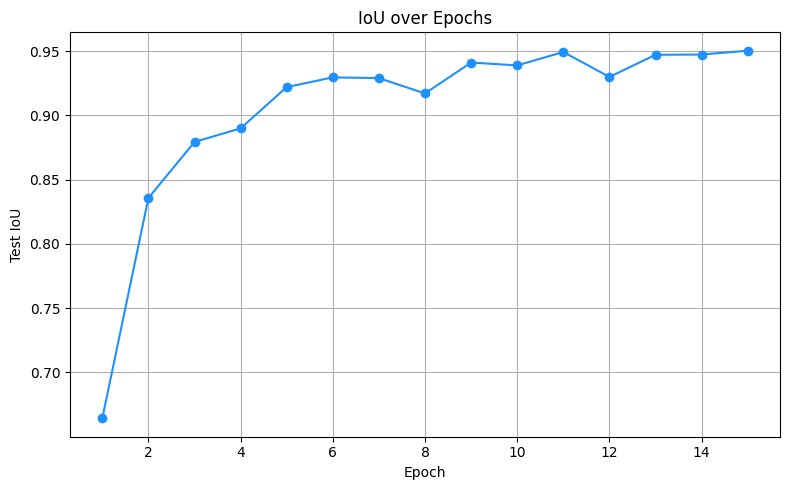

  >> Best model saved at epoch 15 with IoU: 0.9504
[10/89] Loss: 0.0910 Train Acc: 0.9733
[20/89] Loss: 0.0923 Train Acc: 0.9697
[30/89] Loss: 0.0711 Train Acc: 0.9770
[40/89] Loss: 0.0801 Train Acc: 0.9720
[50/89] Loss: 0.0659 Train Acc: 0.9797
[60/89] Loss: 0.0554 Train Acc: 0.9836
[70/89] Loss: 0.0605 Train Acc: 0.9812
[80/89] Loss: 0.0585 Train Acc: 0.9814
Epoch: 16, Test IoU: 0.9459


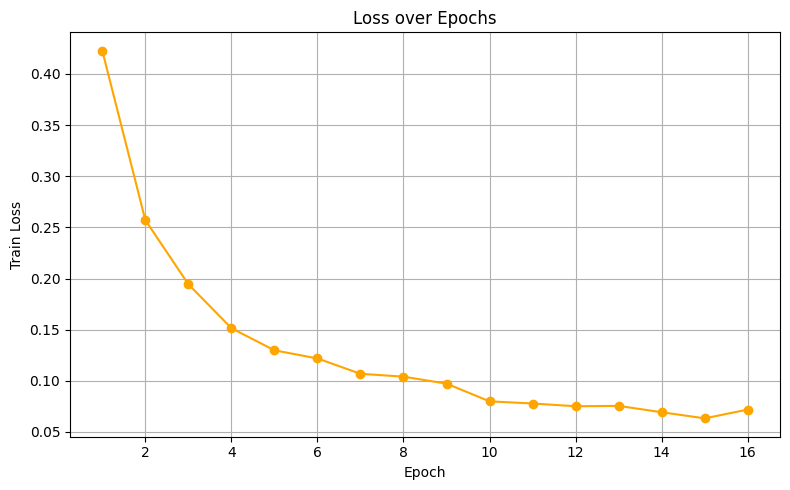

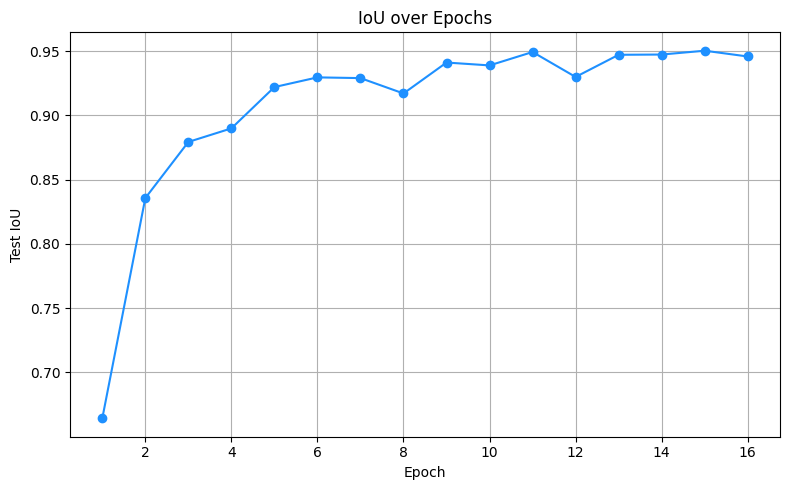

[10/89] Loss: 0.0575 Train Acc: 0.9821
[20/89] Loss: 0.0540 Train Acc: 0.9830
[30/89] Loss: 0.0581 Train Acc: 0.9810
[40/89] Loss: 0.0802 Train Acc: 0.9727
[50/89] Loss: 0.0678 Train Acc: 0.9781
[60/89] Loss: 0.0558 Train Acc: 0.9822
[70/89] Loss: 0.0657 Train Acc: 0.9813
[80/89] Loss: 0.0649 Train Acc: 0.9796
Epoch: 17, Test IoU: 0.9526


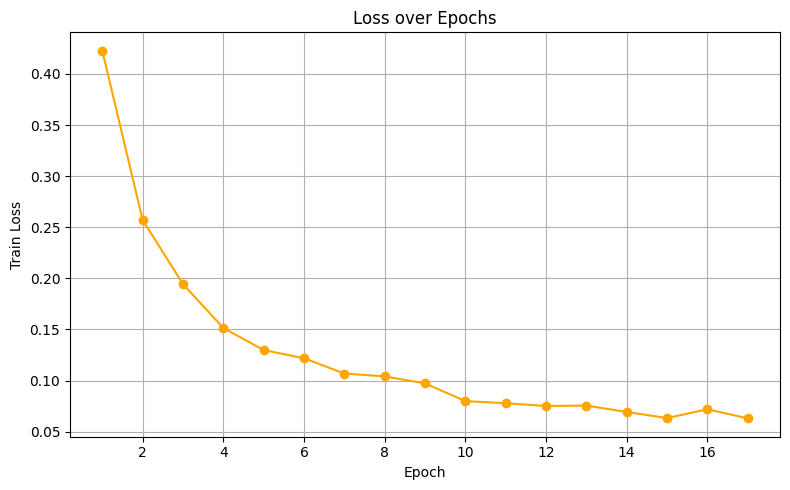

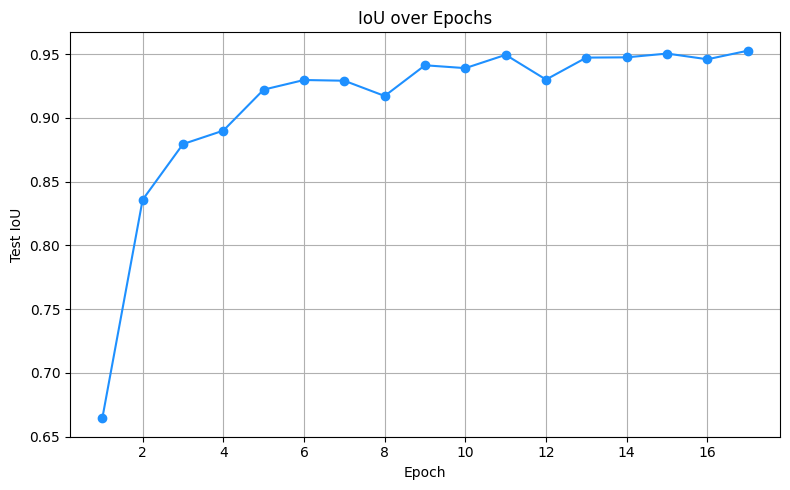

  >> Best model saved at epoch 17 with IoU: 0.9526
[10/89] Loss: 0.0691 Train Acc: 0.9797
[20/89] Loss: 0.0522 Train Acc: 0.9835
[30/89] Loss: 0.0712 Train Acc: 0.9773
[40/89] Loss: 0.0390 Train Acc: 0.9878
[50/89] Loss: 0.0625 Train Acc: 0.9794
[60/89] Loss: 0.0531 Train Acc: 0.9833
[70/89] Loss: 0.0506 Train Acc: 0.9841
[80/89] Loss: 0.0427 Train Acc: 0.9864
Epoch: 18, Test IoU: 0.9585


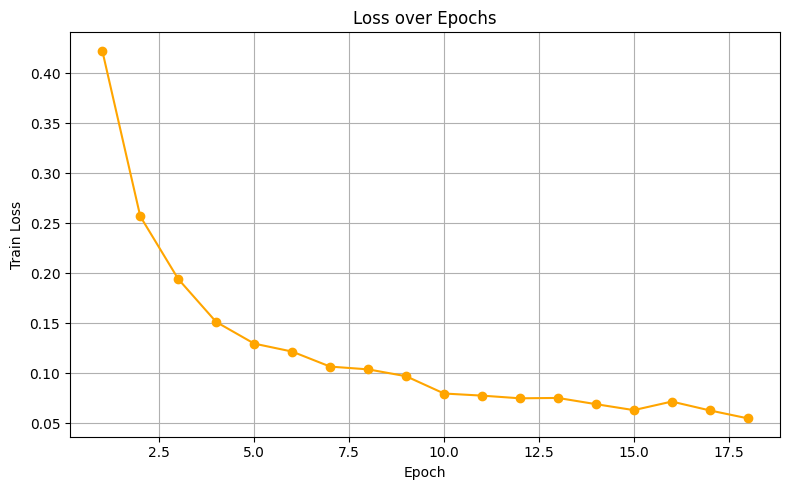

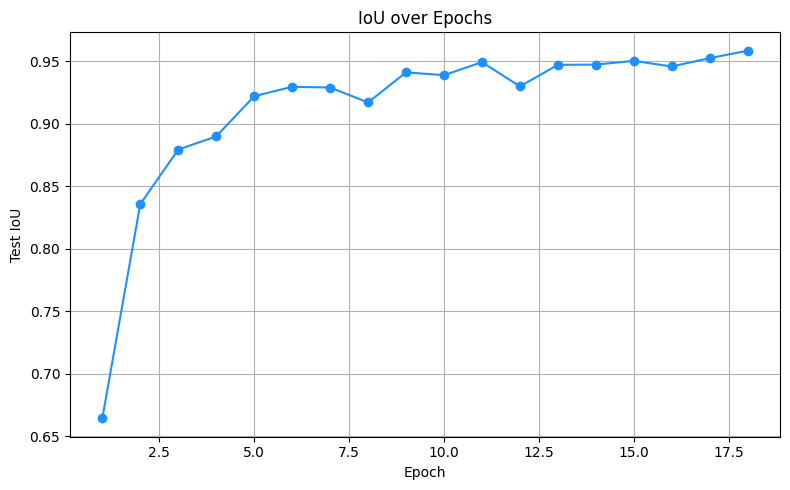

  >> Best model saved at epoch 18 with IoU: 0.9585
[10/89] Loss: 0.0497 Train Acc: 0.9840
[20/89] Loss: 0.0553 Train Acc: 0.9823
[30/89] Loss: 0.0628 Train Acc: 0.9790
[40/89] Loss: 0.0430 Train Acc: 0.9865
[50/89] Loss: 0.0508 Train Acc: 0.9844
[60/89] Loss: 0.0425 Train Acc: 0.9868
[70/89] Loss: 0.0832 Train Acc: 0.9749
[80/89] Loss: 0.0480 Train Acc: 0.9870
Epoch: 19, Test IoU: 0.9578


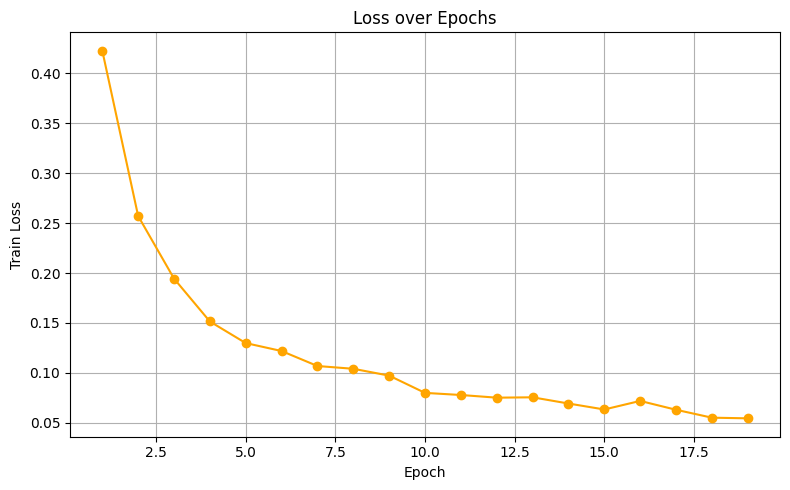

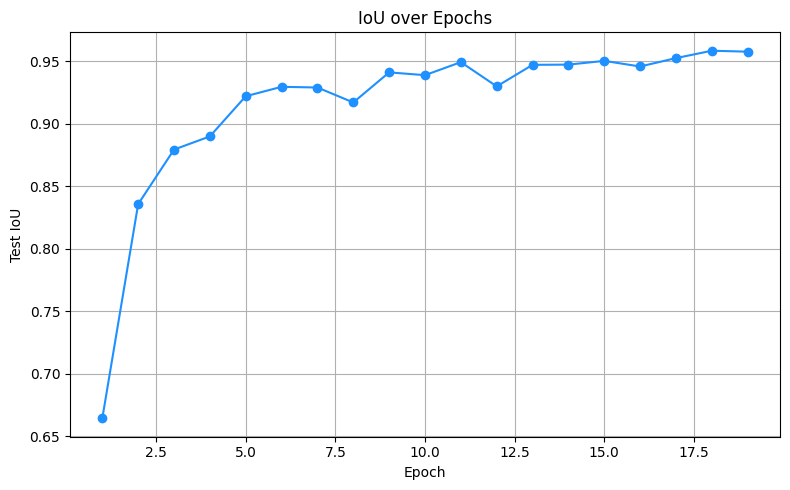

[10/89] Loss: 0.0535 Train Acc: 0.9832
[20/89] Loss: 0.0570 Train Acc: 0.9827
[30/89] Loss: 0.0554 Train Acc: 0.9825
[40/89] Loss: 0.0663 Train Acc: 0.9786
[50/89] Loss: 0.0481 Train Acc: 0.9849
[60/89] Loss: 0.0567 Train Acc: 0.9812
[70/89] Loss: 0.0374 Train Acc: 0.9890
[80/89] Loss: 0.0482 Train Acc: 0.9852
Epoch: 20, Test IoU: 0.9570


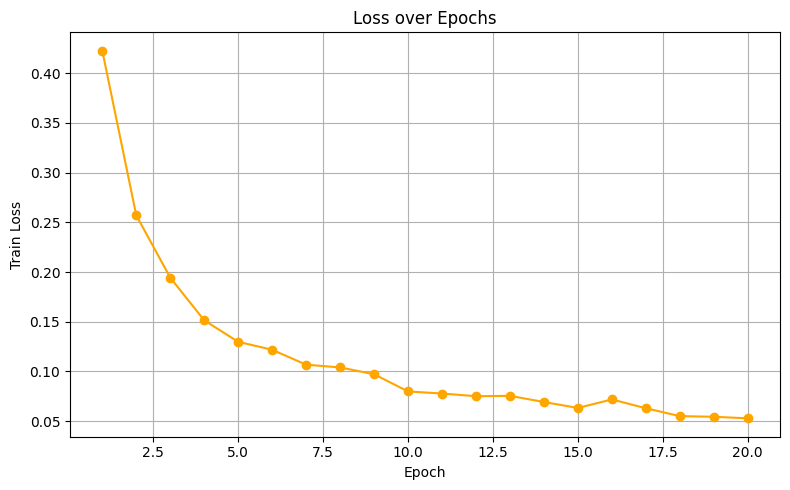

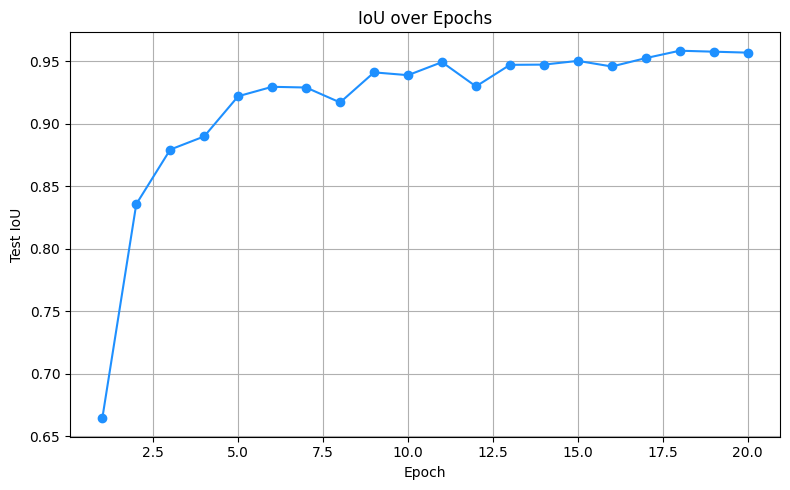

CPU times: user 41min 2s, sys: 9.27 s, total: 41min 12s
Wall time: 41min 46s


In [ ]:
%%time
iou_list = []
loss_list = []

best_iou = 0.0  # or float('-inf') if you're maximizing
best_model_path = "DGCNN_S.pth"

for epoch in range(1, 21):
    loss, acc = train()
    loss_list.append(loss)
    iou = test(test_loader)
    iou_list.append(iou)
    print(f'Epoch: {epoch:02d}, Test IoU: {iou:.4f}')
    plot_loss_over_epochs(loss_list)
    plot_iou_over_epochs(iou_list)
    scheduler.step()
    if iou > best_iou:
        best_iou = iou
        torch.save(model.state_dict(), best_model_path)
        print(f"  >> Best model saved at epoch {epoch} with IoU: {best_iou:.4f}")



In [ ]:
print(max(iou_list))


0.9585443735122681


#Test


In [ ]:
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [ ]:
import os
import numpy as np
from pathlib import Path

@torch.no_grad()
def predict_and_save_per_sample(loader, output_dir="break_result"):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    y_map = torch.empty(loader.dataset.num_classes, device=device).long()
    idx = 0  # sample index

    for data in loader:
        data = data.to(device)
        outs = model(data)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)  # assume input is point positions

        ys = data.y.split(sizes)
        categories = data.category.tolist()

        for x, out, y, category in zip(xs, outs.split(sizes), ys, categories):
            category_str = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category_str]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)

            y_pred = out[:, part].argmax(dim=-1)
            y_true = y_map[y]

            # Save as npz
            file_path = Path(output_dir) / f"sample_{idx:04d}.npz"
            np.savez_compressed(
                file_path,
                x=x.cpu().numpy(),             # 3D points
                y_true=y_true.cpu().numpy(),   # ground truth labels
                y_pred=y_pred.cpu().numpy()    # predicted labels
            )
            idx += 1

    print(f"Saved {idx} samples to: {output_dir}")
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


gt_cmap = np.array([
    [0.121, 0.466, 0.705],  # Blue for class 0
    [1.000, 0.498, 0.054],  # Orange for class 1
])
pred_cmap = np.array([
    [0.054, 0.705, 0.054],  # Blue
    [1.000, 0.498, 0.054],  # Orange
])

def visualize_sample_npz(file_path):
    data = np.load(file_path)
    x = data['x']           # shape: (N, 3)
    y_true = data['y_true'] # shape: (N,)
    print(np.unique(y_true))
    y_pred = data['y_pred'] # shape: (N,)
    print(np.unique(y_pred))

    gt_colors = gt_cmap[y_true]
    pred_colors = pred_cmap[y_pred]

    fig = plt.figure(figsize=(12, 6))

    # --- Ground Truth ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(x[:, 0], x[:, 1], x[:, 2], c=gt_colors, s=5)
    ax1.set_title("Ground Truth Labels")
    ax1.axis('off')

    # --- Prediction ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(x[:, 0], x[:, 1], x[:, 2], c=pred_colors, s=5)
    ax2.set_title("Predicted Labels")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()




In [ ]:

@torch.no_grad()
def eval_value(loader):
    model.eval()

    ious, categories = [], []
    correct, total = 0, 0  # For accuracy
    y_map = torch.empty(loader.dataset.num_classes, device=device).long()

    for data in loader:
        data = data.to(device)
        outs = model(data)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        for out, y, category in zip(outs.split(sizes), data.y.split(sizes),
                                    data.category.tolist()):
            category = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)

            pred = out[:, part].argmax(dim=-1)
            target = y_map[y]

            correct += (pred == target).sum().item()
            total += target.numel()

            iou = jaccard_index(pred, target,
                                num_classes=part.size(0), absent_score=1.0)
            ious.append(iou)

        categories.append(data.category)

    iou = torch.tensor(ious, device=device)
    category = torch.cat(categories, dim=0)

    mean_iou = scatter(iou, category, reduce='mean')  # Per-category IoU.
    accuracy = correct / total

    return accuracy, float(mean_iou.mean())  # Return both Accuracy and Mean IoU

In [ ]:
acc, miou = eval_value(test_loader)
print(f"Accuracy: {acc:.4f}, Mean IoU: {miou:.4f}")

Accuracy: 0.9825, Mean IoU: 0.9585


In [ ]:
predict_and_save_per_sample(test_loader)

Saved 266 samples to: break_result


Sample_0040.npz
[0 1]
[0 1]


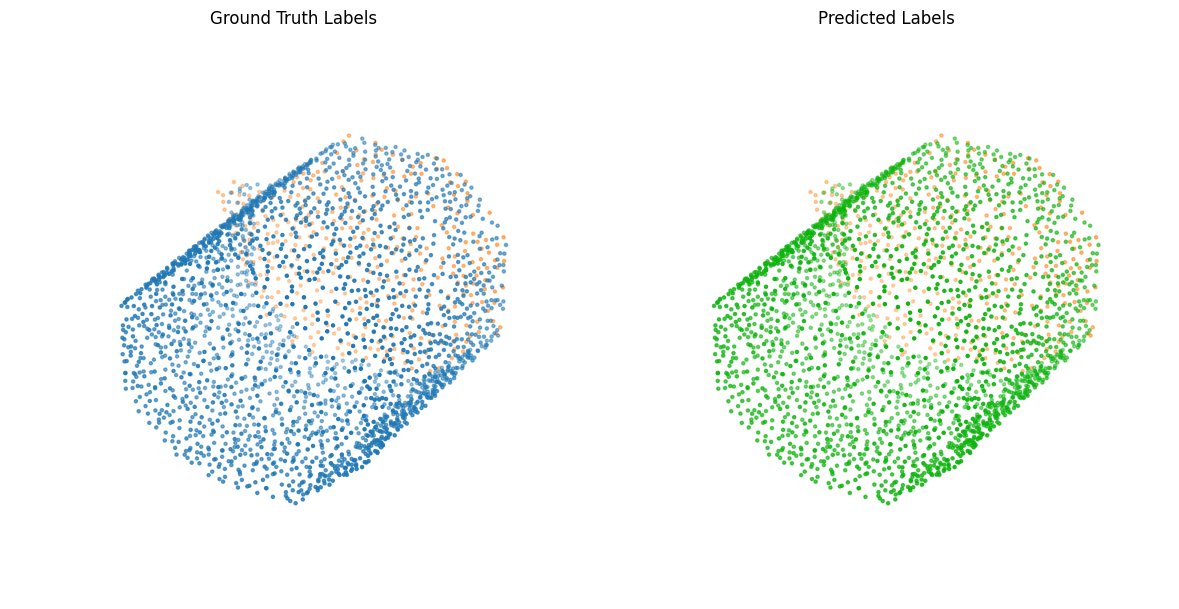

In [ ]:
idx = random.randint(0, 266 )
print(f"Sample_{idx:04d}.npz")
visualize_sample_npz(f"/content/break_result/sample_{idx:04d}.npz")

#fanta


In [ ]:
!rm -r /content/data2

In [ ]:
!unzip /content/processed_fanta_v4.zip -d /content/temp_extract
!mkdir /content/data2
!mkdir /content/data2/raw
!mv /content/temp_extract/processed_fanta_v4/* /content/data2/raw
!rm -r /content/temp_extract

Archive:  /content/processed_fanta_v4.zip
   creating: /content/temp_extract/processed_fanta_v4/
   creating: /content/temp_extract/processed_fanta_v4/abc/
  inflating: /content/temp_extract/processed_fanta_v4/abc/00002.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00003.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00005.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00006.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00008.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00011.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00012.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00013.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00014.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00015.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00016.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00017.txt  
  in

In [ ]:

class FantaBrk(InMemoryDataset):
    r"""The ShapeNet part level segmentation dataset from the `"A Scalable
    Active Framework for Region Annotation in 3D Shape Collections"
    <http://web.stanford.edu/~ericyi/papers/part_annotation_16_small.pdf>`_
    paper, containing about 17,000 3D shape point clouds from 16 shape
    categories.
    Each category is annotated with 2 to 6 parts.

    Args:
        root (str): Root directory where the dataset should be saved.
        categories (str or [str], optional): The category of the CAD models
            (one or a combination of :obj:`"Airplane"`, :obj:`"Bag"`,
            :obj:`"Cap"`, :obj:`"Car"`, :obj:`"Chair"`, :obj:`"Earphone"`,
            :obj:`"Guitar"`, :obj:`"Knife"`, :obj:`"Lamp"`, :obj:`"Laptop"`,
            :obj:`"Motorbike"`, :obj:`"Mug"`, :obj:`"Pistol"`, :obj:`"Rocket"`,
            :obj:`"Skateboard"`, :obj:`"Table"`).
            Can be explicitly set to :obj:`None` to load all categories.
            (default: :obj:`None`)
        include_normals (bool, optional): If set to :obj:`False`, will not
            include normal vectors as input features to :obj:`data.x`.
            As a result, :obj:`data.x` will be :obj:`None`.
            (default: :obj:`True`)
        split (str, optional): If :obj:`"train"`, loads the training dataset.
            If :obj:`"val"`, loads the validation dataset.
            If :obj:`"trainval"`, loads the training and validation dataset.
            If :obj:`"test"`, loads the test dataset.
            (default: :obj:`"trainval"`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10 10
        :header-rows: 1

        * - #graphs
          - #nodes
          - #edges
          - #features
          - #classes
        * - 16,881
          - ~2,616.2
          - 0
          - 3
          - 50
    """

    url = ('https://shapenet.cs.stanford.edu/media/'
           'shapenetcore_partanno_segmentation_benchmark_v0_normal.zip')

    # In case `shapenet.cs.stanford.edu` is offline, try to download the data
    # from Kaggle instead (requires login):
    # https://www.kaggle.com/datasets/mitkir/shapenet/download?datasetVersionNumber=1

    category_ids = {'All_Statue': 'abc'}



    seg_classes = {'All_Statue': [0, 1]}

    def __init__(
        self,
        root: str,
        categories: Optional[Union[str, List[str]]] = None,
        include_normals: bool = True,
        split: str = 'trainval',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        if categories is None:
            categories = list(self.category_ids.keys())
        if isinstance(categories, str):
            categories = [categories]
        print(categories)
        assert all(category in self.category_ids for category in categories)
        self.categories = categories
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'val':
            path = self.processed_paths[1]
        elif split == 'test':
            path = self.processed_paths[2]
        elif split == 'trainval':
            path = self.processed_paths[3]
        else:
            raise ValueError(f'Split {split} found, but expected either '
                             'train, val, trainval or test')

        self.load(path)

        assert isinstance(self._data, Data)
        self._data.x = self._data.x if include_normals else None

        self.y_mask = torch.zeros((len(self.seg_classes.keys()),len(self.seg_classes.keys())*2),
                                  dtype=torch.bool)
        for i, labels in enumerate(self.seg_classes.values()):
            self.y_mask[i, labels] = 1

    @property
    def num_classes(self) -> int:
        return self.y_mask.size(-1)

    @property
    def raw_file_names(self) -> List[str]:
        return list(self.category_ids.values()) + ['train_test_split']

    @property
    def processed_file_names(self) -> List[str]:
        cats = '_'.join([cat[:3].lower() for cat in self.categories])
        return [
            osp.join(f'{cats}_{split}.pt')
            for split in ['train', 'val', 'test', 'trainval']
        ]

    def download(self) -> None:
        pass

    def process_filenames(self, filenames: List[str]) -> List[Data]:
        rank_ids = {'abc': 0}
        data_list = []
        categories_ids = [self.category_ids[cat] for cat in self.categories]
        cat_idx = {categories_ids[i]: i for i in range(len(categories_ids))}

        for name in filenames:
            cat = name.split(osp.sep)[0]
            if cat not in categories_ids:
                continue
            my_custom_idx = rank_ids[cat]
            tensor = read_txt_array(osp.join(self.raw_dir, name))
            pos = tensor[:, :3]
            x = tensor[:, 3:6]
            y = tensor[:, -1].type(torch.long)+2*my_custom_idx
            data = Data(pos=pos, x=x, y=y, category=cat_idx[cat])
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        return data_list

    def process(self) -> None:
        trainval = []
        for i, split in enumerate(['train', 'val', 'test']):
            path = osp.join(self.raw_dir, 'train_test_split',
                            f'shuffled_{split}_file_list.json')
            with open(path) as f:
                filenames = [
                    osp.sep.join(name.split('/')[1:]) + '.txt'
                    for name in json.load(f)
                ]  # Removing first directory.
            data_list = self.process_filenames(filenames)
            if split == 'train' or split == 'val':
                trainval += data_list
            self.save(data_list, self.processed_paths[i])
        self.save(trainval, self.processed_paths[3])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, '
                f'categories={self.categories})')


In [ ]:
category = None  # Pass in `None` to train on all categories.
path = "/content/data2"
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])
pre_transform = T.NormalizeScale()
train_dataset2 = FantaBrk(path, category, split='trainval', transform=transform,
                         pre_transform=pre_transform)
test_dataset2 = FantaBrk(path, category, split='test',
                        pre_transform=pre_transform)
train_loader2 = DataLoader(train_dataset2, batch_size=12, shuffle=True,
                          num_workers=2)
test_loader2 = DataLoader(test_dataset2, batch_size=12, shuffle=False,
                         num_workers=2)

['All_Statue']


Processing...


['All_Statue']


Done!


Unique classes [0 1]


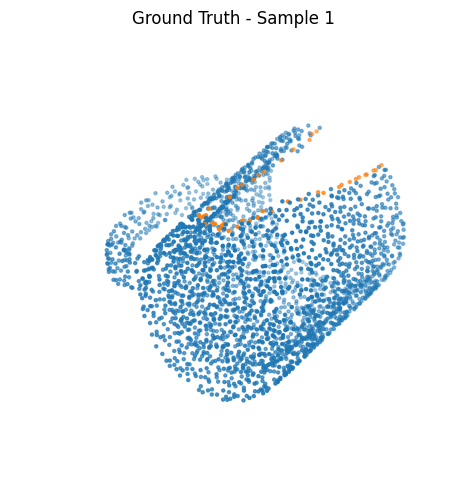

Unique classes [0 1]


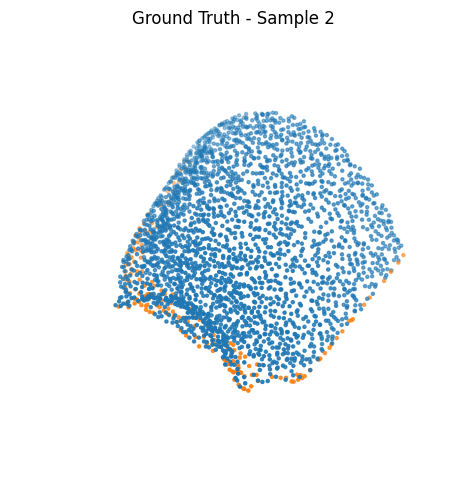

Unique classes [0 1]


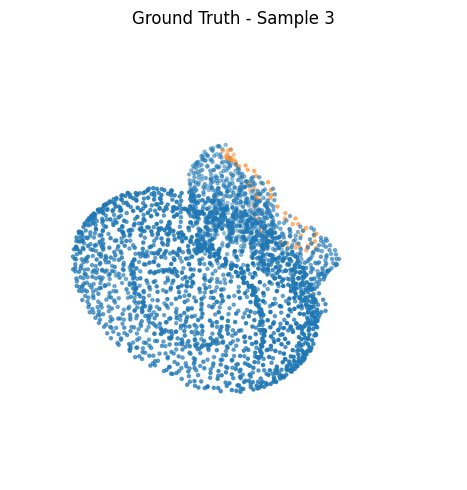

Unique classes [0 1]


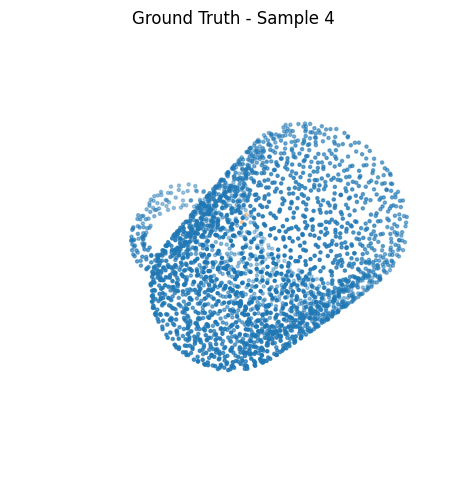

In [ ]:
visualize_ground_truth_3d(test_loader2, num_samples=4)

In [ ]:
import torch

@torch.no_grad()
def eval_value_unseen(loader):
    model.eval()

    ious = []
    correct, total = 0, 0

    for data in loader:
        data = data.to(device)
        out = model(data)  # Shape: [num_points, num_classes]

        # Predict across ALL classes
        pred = out.argmax(dim=-1)%2
        # print(pred)
        target = data.y

        # Accuracy
        correct += (pred == target).sum().item()
        total += target.numel()

        # IoU (mean across classes in this sample)
        iou = jaccard_index(pred, target,num_classes=2, absent_score=1.0)
        ious.append(iou)

    accuracy = correct / total
    mean_iou = np.mean(ious)

    return accuracy, mean_iou, ious


In [ ]:

@torch.no_grad()
def predict_and_save_per_sample_unseen(loader, output_dir="break_result"):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    idx = 0  # sample index

    for data in loader:
        data = data.to(device)
        outs = model(data)  # shape: [num_points, num_classes]

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)   # point positions
        ys = data.y.split(sizes)     # ground truth labels
        outs_split = outs.split(sizes)

        for x, out, y in zip(xs, outs_split, ys):
            y_pred = out.argmax(dim=-1)%2  # predict across all classes
            y_true = y                   # keep original labels

            # Save as npz
            file_path = Path(output_dir) / f"sample_{idx:04d}.npz"
            np.savez_compressed(
                file_path,
                x=x.cpu().numpy(),             # 3D points
                y_true=y_true.cpu().numpy(),   # ground truth labels
                y_pred=y_pred.cpu().numpy()    # predicted labels
            )
            idx += 1

    print(f"Saved {idx} samples to: {output_dir}")

In [ ]:
acc, miou, test = eval_value_unseen(train_loader2)
print(f"Accuracy: {acc:.4f}, Mean IoU: {miou:.4f}")

Accuracy: 0.9507, Mean IoU: 0.5074


In [ ]:
length = predict_and_save_per_sample_unseen(train_loader2,output_dir = "fanta_result")

Saved 120 samples to: fanta_result


Sample_0097.npz
[0 1]
[0 1]


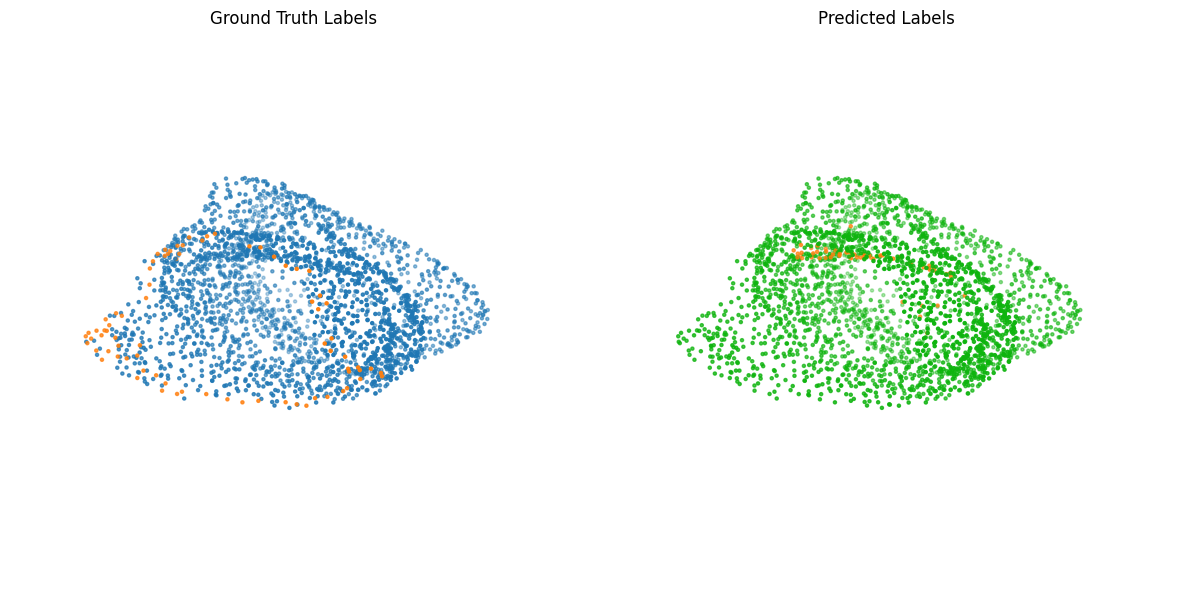

Sample_0062.npz
[0 1]
[0]


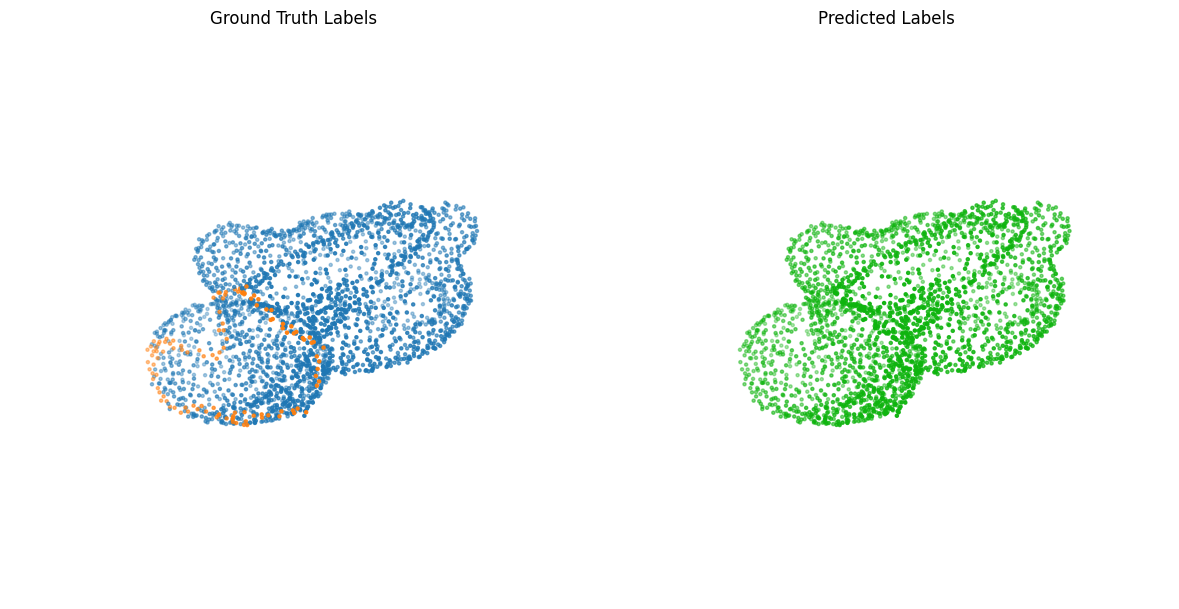

Sample_0023.npz
[0 1]
[0 1]


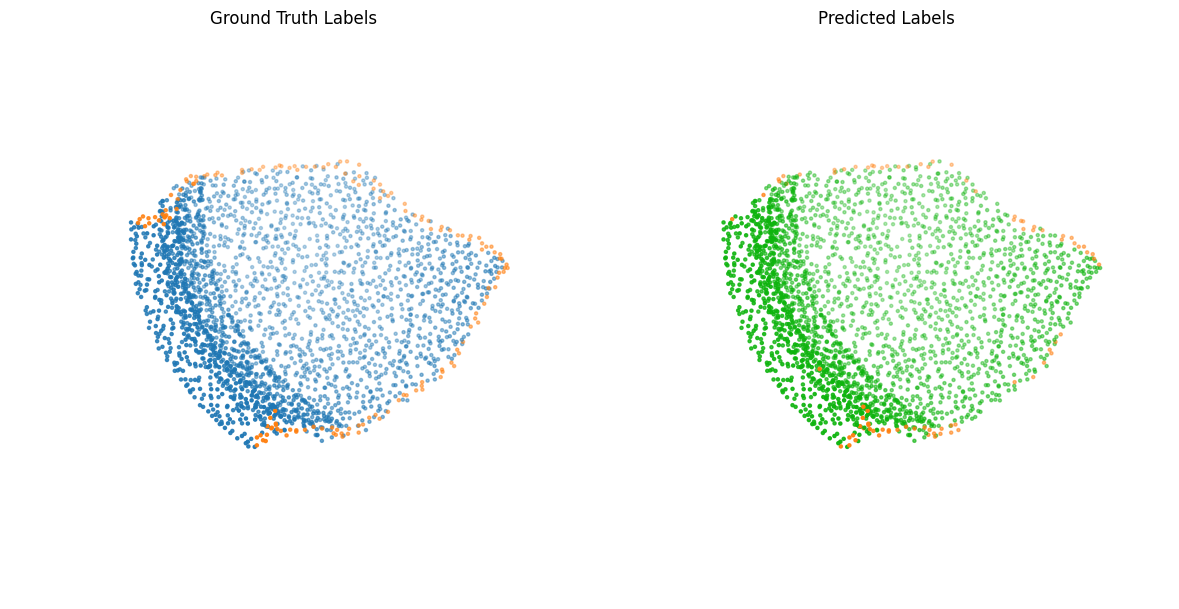

Sample_0067.npz
[0 1]
[0 1]


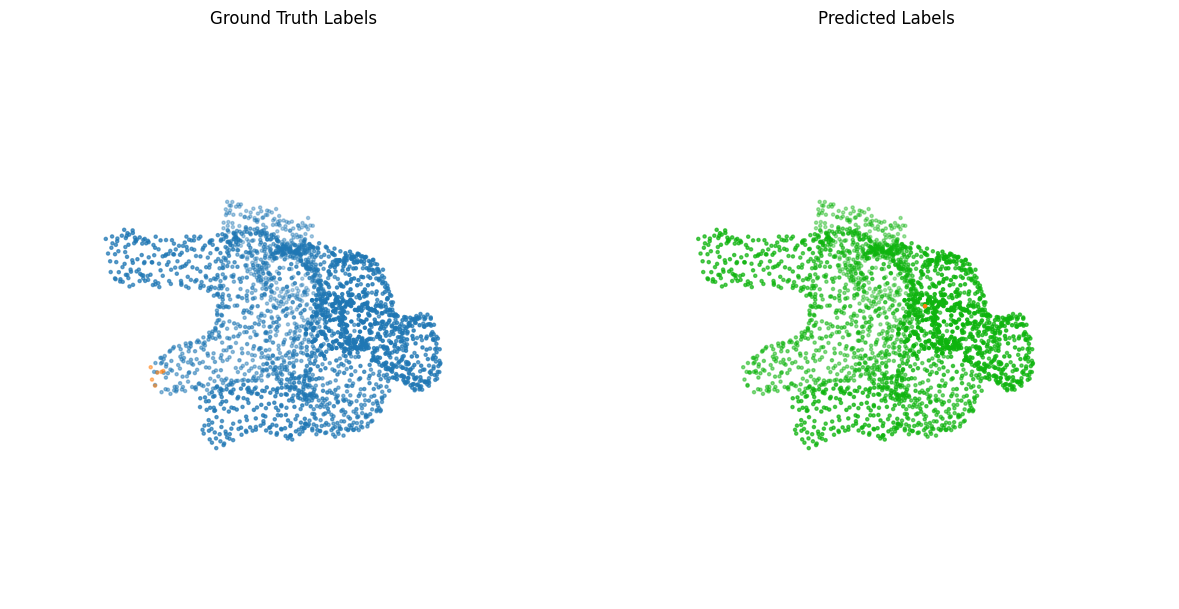

Sample_0031.npz
[0 1]
[0 1]


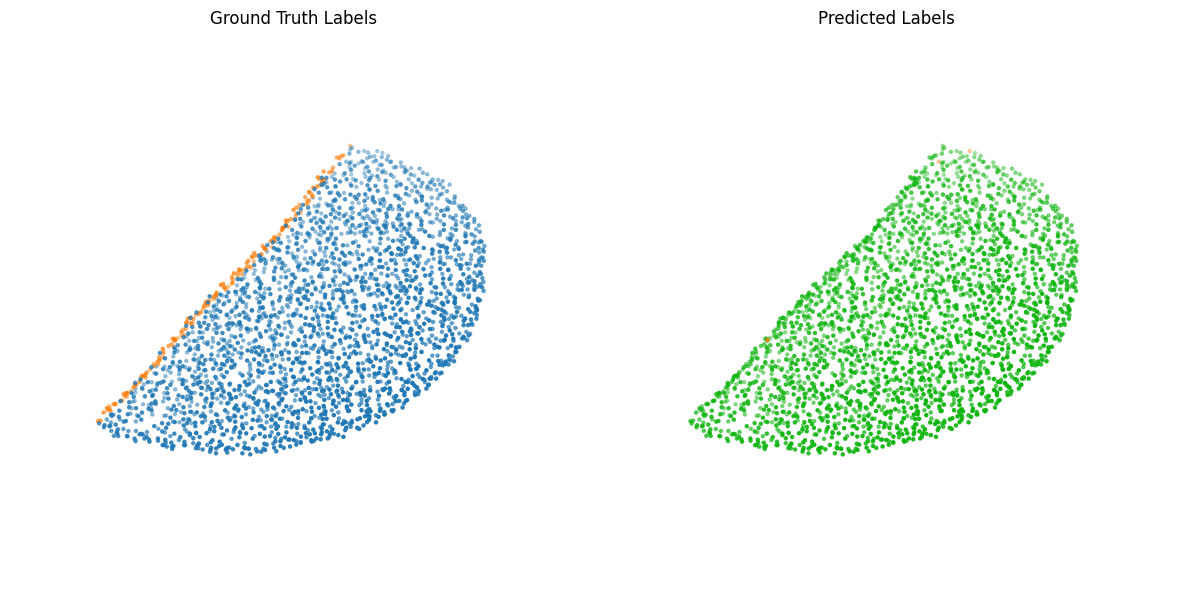

In [ ]:
def wow2():
  idx = random.randint(0, 120)
  print(f"Sample_{idx:04d}.npz")
  visualize_sample_npz(f"/content/fanta_result/sample_{idx:04d}.npz")

wow2()

wow2()

wow2()
wow2()

wow2()

In [ ]:
!mkdir -p output
!cp -r /content/break_result output/
!cp -r /content/fanta_result output/
!cp /content/DGCNN_S.pth output/
!zip -r DGCNN_S.zip output

from google.colab import files
files.download("DGCNN_S.zip")

  adding: output/ (stored 0%)
  adding: output/DGCNN_S.pth (deflated 8%)
  adding: output/break_result/ (stored 0%)
  adding: output/break_result/sample_0248.npz (deflated 1%)
  adding: output/break_result/sample_0140.npz (deflated 1%)
  adding: output/break_result/sample_0051.npz (deflated 0%)
  adding: output/break_result/sample_0009.npz (deflated 0%)
  adding: output/break_result/sample_0203.npz (deflated 3%)
  adding: output/break_result/sample_0006.npz (deflated 0%)
  adding: output/break_result/sample_0184.npz (deflated 0%)
  adding: output/break_result/sample_0110.npz (deflated 0%)
  adding: output/break_result/sample_0127.npz (deflated 0%)
  adding: output/break_result/sample_0216.npz (deflated 0%)
  adding: output/break_result/sample_0230.npz (deflated 0%)
  adding: output/break_result/sample_0187.npz (deflated 1%)
  adding: output/break_result/sample_0123.npz (deflated 0%)
  adding: output/break_result/sample_0221.npz (deflated 0%)
  adding: output/break_result/sample_0144.np

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>